In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [9]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [11]:
res = rle2mask("5 4 11 1 13 1 16 4", 5, 5)
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Xception Model in Keras

In [19]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 256
TRAIN_IMG_SIZE_WIDTH = 256

NO_OF_CLASSES = 4

BATCH_SIZE = 4


In [13]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_path, orig_img_shape, new_img_shape=None, batch_size = BATCH_SIZE, n_channels=1,
                 n_classes=4, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.orig_img_shape = orig_img_shape
        if new_img_shape:
            self.new_img_shape = new_img_shape
        else:
            self.new_img_shape = orig_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.new_img_shape, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, *self.new_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            print(filename)
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            if self.orig_img_shape != self.new_img_shape:
                img = cv2.resize(img, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img
            
            mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *self.orig_img_shape)            
            img_mask_i = Image.fromarray(mask_i, 'L')
            img_mask_np = np.array(img_mask_i) 
            
            if self.orig_img_shape != self.new_img_shape:
                img_mask_np = cv2.resize(img_mask_np, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = img_mask_np
            
        return X, y

In [14]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [15]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def simple_unet_256_segmentation_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down = Conv2D(32, (3, 3), padding='same')(inputs)
    down = BatchNormalization()(down)
    down = Activation('relu')(down)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down) #128

    center = Conv2D(128, (3, 3), padding='same')(down_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up = UpSampling2D((2, 2))(center)
    up = concatenate([down, up], axis=3)
    up = Conv2D(32, (3, 3), padding='same')(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up)

    model = Model(inputs=inputs, outputs=classify)

    return model


In [16]:
simple_model = simple_unet_256_segmentation_model()
simple_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
_____________________________________

In [17]:
from keras.optimizers import RMSprop

simple_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [18]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./Xcep_model_CD_LR0_01.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, RR]
    return [ES, MC, LR]


In [20]:
idx = int(0.8*len(df_train))
train_batches = DataGenerator(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=False)
valid_batches = DataGenerator(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=False)

history = simple_model.fit_generator(train_batches,
                              epochs=3,    
                              validation_data=valid_batches,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(2)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
ca82d646f.jpgcc61104ff.jpg

ca850ca04.jpgcc69501eb.jpg

ca9d7749b.jpgcc73c4765.jpg

cc7920c72.jpgcaab1635c.jpg

303f25bee.jpgcc7c66720.jpg

304083ca3.jpg
cc8f6ee56.jpg
3041d63ba.jpgcc9006402.jpg

3055bb5b8.jpgcc93ff156.jpg


Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
cc9e159dd.jpg6b226dec1.jpg

ccbd751f2.jpg6b36665ef.jpg

ccbeeb18a.jpg
6b39ef48e.jpg
ccd0ad960.jpg
6b3cdd9d1.jpg
ccd94dc85.jpg
af7c08f36.jpg
ccf39a604.jpg
af7c08f36.jpg
cd04164a0.jpg
af7ca17d0.jpg
cd0c2417f.jpg
af7db8470.jpg
cd14c73db.jpg
a0058b3fe.jpg
cd14c73db.jpg
a0155346d.jpg
cd1f8d368.jpg
a01bc9da8.jpg
cd23a468a.jpg
a01c8ce20.jpg
cd23d4841.jpg
8b6cfcf35.jpg
cd316b37e.jpg
8b9681587.jpg
8b9c035ec.jpg
cd3b9899c.jpg
8bab4626b.jpg
cd465dc7d.jpg
8c8914931.jpg
cd475d2a3.jpg
8c8e79fa0.jpgcd4bd2cca.jpg

8c9286f4e.jpg
cd4cd2c97.jpg
cd52bfb5a.jpg8c9286f4e.jpg

4e5b28887.jpg
cd59b3ff5.jpg
4e6514402.jpgcd5b14850.jpg

cd5b14850.jpg
4e7ba4854.jpg
cd634f0

  45/1419 [..............................] - ETA: 6:20 - loss: -0.1882 - dice_coeff: 0.1779 - acc: 0.866565d3d7a0c.jpg
65eed1612.jpg
232256b21.jpg
232a62357.jpg
  46/1419 [..............................] - ETA: 6:15 - loss: -0.1886 - dice_coeff: 0.1779 - acc: 0.8673234ba0510.jpg
235ba1dd3.jpg
3a222ca8a.jpg
3a2f71136.jpg
  47/1419 [..............................] - ETA: 6:10 - loss: -0.1916 - dice_coeff: 0.1784 - acc: 0.86903a43adb32.jpg
3a4edbde9.jpg
c6d3371a8.jpg
c6e9a9d66.jpg
  48/1419 [>.............................] - ETA: 6:06 - loss: -0.2050 - dice_coeff: 0.1841 - acc: 0.8709c6f74537e.jpg
c6f7fe1d2.jpg
4ec0d49df.jpg
4ec252808.jpg
  49/1419 [>.............................] - ETA: 6:02 - loss: -0.2074 - dice_coeff: 0.1843 - acc: 0.87284ecf05db6.jpg
4edc8b817.jpg
2b449bdcf.jpg
2b53843e0.jpg
  50/1419 [>.............................] - ETA: 5:58 - loss: -0.2157 - dice_coeff: 0.1878 - acc: 0.87432b61e04e6.jpg
2b7315722.jpg
b9aa11e17.jpg
b9b07c892.jpg
  51/1419 [>......................

5a0b3a924.jpg
5a188bcf6.jpg
  96/1419 [=>............................] - ETA: 4:24 - loss: -0.3187 - dice_coeff: 0.2376 - acc: 0.88915a1b1601e.jpg
5a2a644d9.jpg
ac03345dc.jpg
ac0682b30.jpg
  97/1419 [=>............................] - ETA: 4:23 - loss: -0.3208 - dice_coeff: 0.2385 - acc: 0.8894ac0bec1fa.jpg
ac15719f1.jpg
08f0b26ac.jpg
08f5c0997.jpg
  98/1419 [=>............................] - ETA: 4:21 - loss: -0.3184 - dice_coeff: 0.2384 - acc: 0.888908f9c685f.jpg
08f9c685f.jpg
018ccdfed.jpg
01919944c.jpg
  99/1419 [=>............................] - ETA: 4:20 - loss: -0.3183 - dice_coeff: 0.2382 - acc: 0.8891019f42c2a.jpg
01a1027ce.jpg
a2d475315.jpg
a2e083f69.jpg
 100/1419 [=>............................] - ETA: 4:19 - loss: -0.3206 - dice_coeff: 0.2400 - acc: 0.8890a2e328f50.jpg
a2e96800f.jpg
a5e9195b6.jpg
a5eb02ff0.jpg
 101/1419 [=>............................] - ETA: 4:18 - loss: -0.3223 - dice_coeff: 0.2407 - acc: 0.8891a5ed4358c.jpg
a5f996baa.jpg
10972add9.jpg
10a3cfbce.jpg
 102/1

 146/1419 [==>...........................]b57c00a3f.jpg - ETA: 3:46 - loss: -0.3607 - dice_coeff: 0.2603 - acc: 0.8946
b57d15322.jpg
c6faa8c55.jpg
c704ec6ca.jpg
 147/1419 [==>...........................]c70702ea2.jpg - ETA: 3:46 - loss: -0.3590 - dice_coeff: 0.2592 - acc: 0.8951
c71558eac.jpg
76532309b.jpg
765876b94.jpg
 148/1419 [==>...........................] - ETA: 3:45 - loss: -0.3621 - dice_coeff: 0.2609 - acc: 0.8950766438a3b.jpg
7668b7312.jpg
ae3ad362b.jpg
ae41ecb3f.jpg
 149/1419 [==>...........................] - ETA: 3:44 - loss: -0.3637 - dice_coeff: 0.2618 - acc: 0.8947ae4555b5b.jpg
ae4753c89.jpg
7242fe32c.jpg
7249ae1f4.jpg
 150/1419 [==>...........................] - ETA: 3:44 - loss: -0.3650 - dice_coeff: 0.2623 - acc: 0.8949724dd91a0.jpg
72613a1e3.jpg
a0ee7a955.jpg
a0fcb1803.jpg
 151/1419 [==>...........................]a10a35f4f.jpg - ETA: 3:44 - loss: -0.3674 - dice_coeff: 0.2632 - acc: 0.8953
a10c18895.jpg
ada844648.jpg
adaa47142.jpg
 152/1419 [==>....................

04594d04e.jpg
046282f58.jpg
 197/1419 [===>..........................] - ETA: 3:23 - loss: -0.3979 - dice_coeff: 0.2758 - acc: 0.9015046c35525.jpg
047fa15d0.jpg
306415665.jpg
306b1dbc1.jpg
 198/1419 [===>..........................] - ETA: 3:23 - loss: -0.3978 - dice_coeff: 0.2755 - acc: 0.90183071e65a5.jpg
30799f11c.jpg
bc3c8163e.jpg
bc67d17de.jpg
 199/1419 [===>..........................] - ETA: 3:23 - loss: -0.3966 - dice_coeff: 0.2759 - acc: 0.9009bc72a7548.jpg
bc73f75a5.jpg
2c4b101db.jpg
2c4fd555c.jpg
 200/1419 [===>..........................] - ETA: 3:22 - loss: -0.3960 - dice_coeff: 0.2756 - acc: 0.90072c56741a3.jpg
2c63f60e3.jpg
5303447ca.jpg
531b9c425.jpg
 201/1419 [===>..........................] - ETA: 3:22 - loss: -0.3971 - dice_coeff: 0.2760 - acc: 0.90085335b8fd7.jpg
533926801.jpg
a345caa40.jpg
a35e7e370.jpg
 202/1419 [===>..........................] - ETA: 3:22 - loss: -0.3976 - dice_coeff: 0.2761 - acc: 0.9010a369c5c1f.jpg
a3714aefc.jpg
196e624f5.jpg
198252b95.jpg
 203/1

 247/1419 [====>.........................] - ETA: 3:08 - loss: -0.4020 - dice_coeff: 0.2771 - acc: 0.90548ab72fe26.jpg
8abd1fbf5.jpg
b08712015.jpg
b08d40600.jpg
 248/1419 [====>.........................] - ETA: 3:07 - loss: -0.4021 - dice_coeff: 0.2771 - acc: 0.9055b091930af.jpg
b0a1cec01.jpg
55c30f544.jpg
55c689cd0.jpg
 249/1419 [====>.........................] - ETA: 3:07 - loss: -0.4014 - dice_coeff: 0.2766 - acc: 0.905655c689cd0.jpg
55ccadff9.jpg
56b9e54ed.jpg
56bf01513.jpg
 250/1419 [====>.........................] - ETA: 3:07 - loss: -0.4024 - dice_coeff: 0.2773 - acc: 0.905556cc8fb98.jpg
56d523688.jpg
4b712bf89.jpg
4b762b230.jpg
 251/1419 [====>.........................] - ETA: 3:06 - loss: -0.4031 - dice_coeff: 0.2776 - acc: 0.90564b902c994.jpg
4b925c919.jpg
6ad48f01b.jpg
6ad48f01b.jpg
6ad67f690.jpg 252/1419 [====>.........................]
 - ETA: 3:06 - loss: -0.4025 - dice_coeff: 0.2774 - acc: 0.90556adf77c70.jpg
9db392648.jpg
9db7cdc58.jpg
 253/1419 [====>..................

8dc0f0966.jpg
8dce4f71f.jpg
 298/1419 [=====>........................] - ETA: 2:54 - loss: -0.4232 - dice_coeff: 0.2870 - acc: 0.90768ddf889d8.jpg
8de366fb3.jpg
252e1de8b.jpg
25337cb38.jpg
 299/1419 [=====>........................]254c52b64.jpg - ETA: 2:54 - loss: -0.4255 - dice_coeff: 0.2880 - acc: 0.9078
25515c2f6.jpg
1795867f2.jpg
179b27647.jpg
 300/1419 [=====>........................] - ETA: 2:54 - loss: -0.4274 - dice_coeff: 0.2889 - acc: 0.9079179f00d93.jpg
17ac2163c.jpg
9d4b9f63c.jpg
9d57d9095.jpg
 301/1419 [=====>........................] - ETA: 2:53 - loss: -0.4284 - dice_coeff: 0.2893 - acc: 0.90809d57d9095.jpg
9d64b3372.jpg
5e88c8a04.jpg
5e8ca0990.jpg
 302/1419 [=====>........................] - ETA: 2:53 - loss: -0.4283 - dice_coeff: 0.2893 - acc: 0.90815e92f8e11.jpg
5ea7bbf5f.jpg
8dfe396ef.jpg
8e01fb963.jpg
 303/1419 [=====>........................] - ETA: 2:53 - loss: -0.4278 - dice_coeff: 0.2890 - acc: 0.90828e08d9cd6.jpg
8e11e6dff.jpg
c2760fc1a.jpg
c27ce861d.jpg
 304/1

 348/1419 [======>.......................] - ETA: 2:43 - loss: -0.4369 - dice_coeff: 0.2937 - acc: 0.90900cf509103.jpg
0cfcad1f5.jpg
800b8c9d1.jpg
8016e642c.jpg
 349/1419 [======>.......................] - ETA: 2:43 - loss: -0.4375 - dice_coeff: 0.2940 - acc: 0.9091801887861.jpg
801d299ac.jpg
b7fd1f63b.jpg
b845c99d9.jpg
 350/1419 [======>.......................] - ETA: 2:43 - loss: -0.4381 - dice_coeff: 0.2943 - acc: 0.9090b845ef149.jpg
b8576af47.jpg
854baa70c.jpg
8562a95b4.jpg
 351/1419 [======>.......................] - ETA: 2:42 - loss: -0.4382 - dice_coeff: 0.2943 - acc: 0.9091856f0b6bd.jpg
857400707.jpg
0c888ecb5.jpg
0c888ecb5.jpg
 352/1419 [======>.......................]0c9ae816d.jpg - ETA: 2:42 - loss: -0.4386 - dice_coeff: 0.2946 - acc: 0.9091
0ca915b9f.jpg
9be9c98eb.jpg
9beece43e.jpg
 353/1419 [======>.......................] - ETA: 2:42 - loss: -0.4384 - dice_coeff: 0.2944 - acc: 0.90919bf40dacc.jpg
9bf863558.jpg
86cbb2d1f.jpg
86d953299.jpg
 354/1419 [======>................

4b16dc9ee.jpg
4b16dc9ee.jpg
 399/1419 [=======>......................]4b1d2a283.jpg - ETA: 2:33 - loss: -0.4500 - dice_coeff: 0.3001 - acc: 0.9101
4b286bf39.jpg
8ed3c433b.jpg
8ed6b8054.jpg
 400/1419 [=======>......................] - ETA: 2:32 - loss: -0.4494 - dice_coeff: 0.2998 - acc: 0.91018ed87432c.jpg
8edd818de.jpg
bbafbaab3.jpg
bbb96273d.jpg
 401/1419 [=======>......................] - ETA: 2:32 - loss: -0.4500 - dice_coeff: 0.3000 - acc: 0.9103bbc220ad9.jpg
bbc246c1b.jpg
1c029a278.jpg
1c0d8bcd0.jpg
 402/1419 [=======>......................] - ETA: 2:32 - loss: -0.4499 - dice_coeff: 0.2999 - acc: 0.91031c18acd30.jpg
1c19efedd.jpg
2999deba3.jpg
299a15c20.jpg
 403/1419 [=======>......................] - ETA: 2:32 - loss: -0.4498 - dice_coeff: 0.2998 - acc: 0.9104299a15c20.jpg
299d06031.jpg
43f6a4177.jpg
43fcd5c0b.jpg
44011d351.jpg
 404/1419 [=======>......................] - ETA: 2:32 - loss: -0.4500 - dice_coeff: 0.3000 - acc: 0.9103441866b3d.jpg
c878411d7.jpg
c87ca8539.jpg
 405/

 449/1419 [========>.....................] - ETA: 2:24 - loss: -0.4618 - dice_coeff: 0.3054 - acc: 0.9124aff01777f.jpg
aff2b8b8a.jpg
7bb25cc94.jpg
7bb3640ce.jpg
 450/1419 [========>.....................] - ETA: 2:23 - loss: -0.4616 - dice_coeff: 0.3052 - acc: 0.91257bde96c82.jpg
7be8a27c8.jpg
7a249b737.jpg
7a2908c51.jpg
 451/1419 [========>.....................] - ETA: 2:23 - loss: -0.4616 - dice_coeff: 0.3051 - acc: 0.91267a31a3b5e.jpg
7a32eba62.jpg
9eed09712.jpg
9eed09712.jpg
9eed4fc7c.jpg
 452/1419 [========>.....................] - ETA: 2:23 - loss: -0.4629 - dice_coeff: 0.3056 - acc: 0.91289ef683a79.jpg
c22ead98c.jpg
c232eea0c.jpg
 453/1419 [========>.....................] - ETA: 2:23 - loss: -0.4645 - dice_coeff: 0.3063 - acc: 0.9129c23ef14ee.jpg
c248ca201.jpg
bba274c50.jpg
bba583ae1.jpg
 454/1419 [========>.....................] - ETA: 2:23 - loss: -0.4640 - dice_coeff: 0.3061 - acc: 0.9130bbae1c48a.jpg
bbaeed54e.jpg
a8b77ce4d.jpg
a8ba23b0a.jpg
 455/1419 [========>..............

846a8ccab.jpg
8478415cf.jpg
 500/1419 [=========>....................] - ETA: 2:15 - loss: -0.4716 - dice_coeff: 0.3094 - acc: 0.9144847b7640a.jpg
8484468e0.jpg
71d3b0598.jpg
71dd5a232.jpg
 501/1419 [=========>....................] - ETA: 2:15 - loss: -0.4722 - dice_coeff: 0.3097 - acc: 0.914571e2bb12a.jpg
71e55c4e5.jpg
58c262a8b.jpg
58e63b56e.jpg
 502/1419 [=========>....................]58ee62fd7.jpg - ETA: 2:15 - loss: -0.4727 - dice_coeff: 0.3099 - acc: 0.9146
58f11e1cb.jpg
4854add54.jpg
4857d0687.jpg
 503/1419 [=========>....................] - ETA: 2:14 - loss: -0.4733 - dice_coeff: 0.3102 - acc: 0.9146485ed6221.jpg
48626da29.jpg
53a21bba1.jpg
53b6d2ab1.jpg
 504/1419 [=========>....................] - ETA: 2:14 - loss: -0.4730 - dice_coeff: 0.3100 - acc: 0.914653c167687.jpg
53e812ced.jpg
bff6cdfad.jpg
bff6cdfad.jpg
bff7d63af.jpg 505/1419 [=========>....................]
 - ETA: 2:14 - loss: -0.4736 - dice_coeff: 0.3103 - acc: 0.9147c0065dcab.jpg
32a6666a3.jpg
32dca5f32.jpg
 506/1

 550/1419 [==========>...................] - ETA: 2:06 - loss: -0.4852 - dice_coeff: 0.3158 - acc: 0.91632dd360833.jpg
2de22f59f.jpg
c34bf9bec.jpg
c34f14586.jpg
 551/1419 [==========>...................] - ETA: 2:06 - loss: -0.4859 - dice_coeff: 0.3161 - acc: 0.9164c34f14586.jpg
c34fc79b6.jpg
b925ef3b7.jpg
b93118acc.jpg
 552/1419 [==========>...................] - ETA: 2:06 - loss: -0.4855 - dice_coeff: 0.3158 - acc: 0.9164b933f4591.jpg
b93cc6719.jpg
01e020dc5.jpg
01ebe0d32.jpg
 553/1419 [==========>...................] - ETA: 2:06 - loss: -0.4848 - dice_coeff: 0.3155 - acc: 0.916401fd320c9.jpg
01fd50e68.jpg
9087518f1.jpg
90b461f2a.jpg
 554/1419 [==========>...................] - ETA: 2:06 - loss: -0.4842 - dice_coeff: 0.3153 - acc: 0.916490b51d4f7.jpg
90b5b429a.jpg
a52f36666.jpg
a53891ed0.jpg
 555/1419 [==========>...................] - ETA: 2:06 - loss: -0.4843 - dice_coeff: 0.3154 - acc: 0.9163a541e2eb6.jpg
a559091c5.jpg
56011ad29.jpg
560a3e98a.jpg
 556/1419 [==========>............

c646462b5.jpg
c6510fb5a.jpg
 601/1419 [===========>..................] - ETA: 1:58 - loss: -0.4892 - dice_coeff: 0.3177 - acc: 0.9173c65471f28.jpg
c66ba3e27.jpg
65841b207.jpg
6588cf973.jpg
 602/1419 [===========>..................] - ETA: 1:58 - loss: -0.4894 - dice_coeff: 0.3179 - acc: 0.9173658ad1fc9.jpg
65903909a.jpg
1755b86e4.jpg
175c0ee12.jpg
 603/1419 [===========>..................] - ETA: 1:58 - loss: -0.4900 - dice_coeff: 0.3181 - acc: 0.9174177a33f57.jpg
178490b45.jpg
943c5abcd.jpg
944ef524a.jpg
 604/1419 [===========>..................] - ETA: 1:58 - loss: -0.4911 - dice_coeff: 0.3185 - acc: 0.9175946227d6c.jpg
94625a99c.jpg
c04b0d160.jpg
c05799ac4.jpg
 605/1419 [===========>..................] - ETA: 1:58 - loss: -0.4911 - dice_coeff: 0.3187 - acc: 0.9175c057d7bc1.jpg
c0598f956.jpg
22827c51d.jpg
2283f2183.jpg
 606/1419 [===========>..................] - ETA: 1:57 - loss: -0.4912 - dice_coeff: 0.3186 - acc: 0.9175229500455.jpg
229906ed1.jpg
2d26b9dda.jpg
2d37a1ebe.jpg
 607/1

 651/1419 [============>.................] - ETA: 1:50 - loss: -0.4971 - dice_coeff: 0.3212 - acc: 0.91919aca6db08.jpg
9ad1ad629.jpg
5b28f3d4a.jpg
5b334d4db.jpg
 652/1419 [============>.................] - ETA: 1:50 - loss: -0.4969 - dice_coeff: 0.3211 - acc: 0.91915b470a696.jpg
5b4e446d3.jpg
7b857d874.jpg
7b8d4b6d4.jpg
 653/1419 [============>.................] - ETA: 1:50 - loss: -0.4967 - dice_coeff: 0.3210 - acc: 0.91927ba0bbe30.jpg
7ba14848e.jpg
81b6f3cca.jpg
81c37d5f1.jpg
 654/1419 [============>.................]81e8d9fd9.jpg - ETA: 1:50 - loss: -0.4973 - dice_coeff: 0.3212 - acc: 0.9192
81f75d1b5.jpg
99d47e124.jpg
99dcc6d72.jpg
 655/1419 [============>.................] - ETA: 1:50 - loss: -0.4975 - dice_coeff: 0.3213 - acc: 0.91929a064450d.jpg
9a18e4457.jpg
311edf4e4.jpg
311f6c34f.jpg
 656/1419 [============>.................] - ETA: 1:50 - loss: -0.4981 - dice_coeff: 0.3216 - acc: 0.9192312224509.jpg
3124b1e5c.jpg
16aabaf79.jpg
16acf1ed9.jpg
 657/1419 [============>..........

9b63ed48c.jpg
9b668835f.jpg
 702/1419 [=============>................] - ETA: 1:42 - loss: -0.5066 - dice_coeff: 0.3255 - acc: 0.92039b72243dc.jpg
9b7974523.jpg
7c83d2da1.jpg
7c847f7b3.jpg
 703/1419 [=============>................] - ETA: 1:42 - loss: -0.5069 - dice_coeff: 0.3256 - acc: 0.92037c8a469a4.jpg
7c90f66d5.jpg
b1b3ec5fd.jpg
b1b3ec5fd.jpg
 704/1419 [=============>................] - ETA: 1:42 - loss: -0.5072 - dice_coeff: 0.3257 - acc: 0.9204b1b94f0fc.jpg
b1b94f0fc.jpg
3ab1a7324.jpg
3ab4ca44c.jpg
 705/1419 [=============>................] - ETA: 1:42 - loss: -0.5068 - dice_coeff: 0.3255 - acc: 0.92043abba0c59.jpg
3abc94d79.jpg
744c6de01.jpg
744c77e7d.jpg
 706/1419 [=============>................] - ETA: 1:42 - loss: -0.5071 - dice_coeff: 0.3257 - acc: 0.9204744e852d6.jpg
7454d922e.jpg
9c1c7f69c.jpg
9c27c1365.jpg
 707/1419 [=============>................] - ETA: 1:42 - loss: -0.5077 - dice_coeff: 0.3259 - acc: 0.92049c2dc4bfc.jpg
9c33cdef5.jpg
5994c3b58.jpg
59a1733a9.jpg
 708/1

 752/1419 [==============>...............] - ETA: 1:35 - loss: -0.5106 - dice_coeff: 0.3271 - acc: 0.9211624e942f6.jpg
6267f94de.jpg
b2c9fde17.jpg
b2cbd553f.jpg
 753/1419 [==============>...............] - ETA: 1:35 - loss: -0.5106 - dice_coeff: 0.3273 - acc: 0.9210b2d4a1767.jpg
b2e59bdaa.jpg
794307d65.jpg
794ab5277.jpg
 754/1419 [==============>...............] - ETA: 1:35 - loss: -0.5101 - dice_coeff: 0.3271 - acc: 0.920979550304c.jpg
795907727.jpg
ad8ffec02.jpg
ad9ad21f4.jpg
 755/1419 [==============>...............] - ETA: 1:34 - loss: -0.5105 - dice_coeff: 0.3273 - acc: 0.9210ada3dacbe.jpg
ada844648.jpg
b4aa8dbf0.jpg
b4b5c6a86.jpg
 756/1419 [==============>...............] - ETA: 1:34 - loss: -0.5105 - dice_coeff: 0.3273 - acc: 0.9209b4cc6a4ed.jpg
b4d309794.jpg
0d22c1559.jpg
0d2a4e766.jpg
 757/1419 [===============>..............] - ETA: 1:34 - loss: -0.5106 - dice_coeff: 0.3273 - acc: 0.92100d365d98c.jpg
0d3d0dbf2.jpg
07b1a9644.jpg
07b627cb9.jpg
 758/1419 [===============>.......

71b3a6858.jpg
71b815a2d.jpg
 803/1419 [===============>..............] - ETA: 1:27 - loss: -0.5198 - dice_coeff: 0.3313 - acc: 0.922271c2116d8.jpg
71ce72925.jpg
06ad83bac.jpg
06ae96c30.jpg
 804/1419 [===============>..............] - ETA: 1:27 - loss: -0.5200 - dice_coeff: 0.3313 - acc: 0.922206aed81ba.jpg
06b384e78.jpg
07c3d6d77.jpg
07c8ba1d5.jpg
 805/1419 [================>.............] - ETA: 1:27 - loss: -0.5201 - dice_coeff: 0.3315 - acc: 0.922207c8ba1d5.jpg
07c8c77a3.jpg
7c5918274.jpg
7c5918274.jpg
 806/1419 [================>.............]7c6e58a02.jpg - ETA: 1:27 - loss: -0.5197 - dice_coeff: 0.3313 - acc: 0.9222
7c764812d.jpg
34349ea9e.jpg
343e101ee.jpg
 807/1419 [================>.............] - ETA: 1:27 - loss: -0.5196 - dice_coeff: 0.3312 - acc: 0.922234561de46.jpg
345cf1dc3.jpg
49416ce82.jpg
494ead378.jpg
 808/1419 [================>.............] - ETA: 1:26 - loss: -0.5194 - dice_coeff: 0.3311 - acc: 0.9223495d5828b.jpg
496790c19.jpg
549613483.jpg
549aa706e.jpg
 809/1

 853/1419 [=================>............] - ETA: 1:20 - loss: -0.5211 - dice_coeff: 0.3316 - acc: 0.923297a933eaa.jpg
97b77f9e6.jpg
7329b8668.jpg
732bd67ee.jpg
 854/1419 [=================>............] - ETA: 1:20 - loss: -0.5214 - dice_coeff: 0.3318 - acc: 0.923273303e8a0.jpg
733e36f26.jpg
b8b4d7133.jpg
b8b5ed4d0.jpg
 855/1419 [=================>............] - ETA: 1:19 - loss: -0.5212 - dice_coeff: 0.3316 - acc: 0.9232b8b5ed4d0.jpg
b8ba151b1.jpg
c5a65a795.jpg
c5af9872c.jpg
 856/1419 [=================>............] - ETA: 1:19 - loss: -0.5209 - dice_coeff: 0.3315 - acc: 0.9232c5b08d4e3.jpg
c5b08d4e3.jpg
459617182.jpg
459790d82.jpg
 857/1419 [=================>............] - ETA: 1:19 - loss: -0.5209 - dice_coeff: 0.3315 - acc: 0.9232459840244.jpg
4598f8be0.jpg
636852a01.jpg
636bad9bd.jpg
 858/1419 [=================>............] - ETA: 1:19 - loss: -0.5207 - dice_coeff: 0.3314 - acc: 0.9232638531c87.jpg
638b05d55.jpg
bf83e7037.jpg
bf96d0602.jpg
 859/1419 [=================>.....

a15500c55.jpg
a16672b15.jpg
 904/1419 [==================>...........] - ETA: 1:12 - loss: -0.5252 - dice_coeff: 0.3332 - acc: 0.9241a17a84d8f.jpg
a187d1897.jpg
1d00226a0.jpg
1d0521214.jpg
 905/1419 [==================>...........] - ETA: 1:12 - loss: -0.5256 - dice_coeff: 0.3334 - acc: 0.92411d0861206.jpg
1d28002da.jpg
8645f73f1.jpg
8648b2010.jpg
 906/1419 [==================>...........] - ETA: 1:12 - loss: -0.5255 - dice_coeff: 0.3333 - acc: 0.92428651a4a06.jpg
865574894.jpg
ab2b3d3d9.jpg
ab312df89.jpg
 907/1419 [==================>...........] - ETA: 1:12 - loss: -0.5254 - dice_coeff: 0.3332 - acc: 0.9242ab3fed191.jpg
ab4fab99e.jpg
3c5e34bfa.jpg
3c79d2e28.jpg
 908/1419 [==================>...........] - ETA: 1:12 - loss: -0.5253 - dice_coeff: 0.3331 - acc: 0.92423c7e032fc.jpg
3c8312241.jpg
915b0078c.jpg
9163ec76b.jpg
 909/1419 [==================>...........] - ETA: 1:12 - loss: -0.5253 - dice_coeff: 0.3331 - acc: 0.924391649dea7.jpg
91696aaca.jpg
8445de2d9.jpg
844a48ae2.jpg
 910/1

 954/1419 [===================>..........] - ETA: 1:05 - loss: -0.5268 - dice_coeff: 0.3339 - acc: 0.9246286f459e6.jpg
286f459e6.jpg
9f34c4775.jpg
9f43931af.jpg
 955/1419 [===================>..........] - ETA: 1:05 - loss: -0.5267 - dice_coeff: 0.3339 - acc: 0.92469f6016bcc.jpg
9f7063103.jpg
1c3a58b06.jpg
1c493aed1.jpg
 956/1419 [===================>..........] - ETA: 1:05 - loss: -0.5268 - dice_coeff: 0.3340 - acc: 0.92461c61eaea9.jpg
1c6625114.jpg
00f1665e6.jpg
00f6e702c.jpg
 957/1419 [===================>..........] - ETA: 1:05 - loss: -0.5266 - dice_coeff: 0.3339 - acc: 0.924701053d28f.jpg
010db68d1.jpg
71fd2d0cc.jpg
7202e52d8.jpg
 958/1419 [===================>..........] - ETA: 1:05 - loss: -0.5267 - dice_coeff: 0.3339 - acc: 0.9247720e3f026.jpg
7210ffc2d.jpg
3af904b99.jpg
3afb8f1bc.jpg
 959/1419 [===================>..........] - ETA: 1:04 - loss: -0.5271 - dice_coeff: 0.3340 - acc: 0.92473b1479719.jpg
3b2b910c7.jpg
a508dd004.jpg
a508dd004.jpg
 960/1419 [===================>...

c5cd270f2.jpg
1005/1419 [====================>.........] - ETA: 58s - loss: -0.5303 - dice_coeff: 0.3351 - acc: 0.9256c5da9e8c7.jpg
c5dbdf433.jpg
0f4bf08bd.jpg
0f65a99d2.jpg
1006/1419 [====================>.........] - ETA: 58s - loss: -0.5304 - dice_coeff: 0.3352 - acc: 0.92560f7b0f4ab.jpg
0f8305adb.jpg
a5aa4829b.jpg
a5ac1a50b.jpg
1007/1419 [====================>.........] - ETA: 58s - loss: -0.5306 - dice_coeff: 0.3353 - acc: 0.9256a5b23c751.jpg
a5b484508.jpg
878824b35.jpg
87a5ac2f8.jpg
1008/1419 [====================>.........] - ETA: 58s - loss: -0.5300 - dice_coeff: 0.3352 - acc: 0.925587ae117e9.jpg
87c733c21.jpg
b9bef4fe1.jpg
b9dbbf8ac.jpg
1009/1419 [====================>.........] - ETA: 57s - loss: -0.5300 - dice_coeff: 0.3351 - acc: 0.9256b9e47cf86.jpg
b9f5fe198.jpg
439f1a016.jpg
43a450e62.jpg
1010/1419 [====================>.........] - ETA: 57s - loss: -0.5299 - dice_coeff: 0.3351 - acc: 0.925643b6618bf.jpg
43bb3a898.jpg
7150719e7.jpg
71553a0d8.jpg
1011/1419 [===============

1056/1419 [=====================>........] - ETA: 51s - loss: -0.5332 - dice_coeff: 0.3368 - acc: 0.92587f08f6d42.jpg
7f1b37606.jpg
4f64d3b50.jpg
4f6a3b984.jpg
1057/1419 [=====================>........] - ETA: 51s - loss: -0.5331 - dice_coeff: 0.3368 - acc: 0.92584f70ba311.jpg
4f77c0179.jpg
6bc7c35cd.jpg
6bd0ca419.jpg
1058/1419 [=====================>........] - ETA: 51s - loss: -0.5335 - dice_coeff: 0.3369 - acc: 0.92596bd87aed9.jpg
6bdf447c5.jpg
95a8e91c4.jpg
95aff808c.jpg
1059/1419 [=====================>........] - ETA: 50s - loss: -0.5336 - dice_coeff: 0.3369 - acc: 0.925995b95a425.jpg
95d88196d.jpg
13c1d516a.jpg
13c27aa5b.jpg
1060/1419 [=====================>........] - ETA: 50s - loss: -0.5337 - dice_coeff: 0.3370 - acc: 0.925913c9921d2.jpg
13ca110ae.jpg
9345f1250.jpg
9347e65bb.jpg
1061/1419 [=====================>........] - ETA: 50s - loss: -0.5340 - dice_coeff: 0.3371 - acc: 0.9259935654dc9.jpg
936e1759a.jpg
644f9c71d.jpg
644f9c71d.jpg
1062/1419 [=====================>.......

1107/1419 [======================>.......] - ETA: 44s - loss: -0.5364 - dice_coeff: 0.3383 - acc: 0.92620141c9bf3.jpg
0148e9891.jpg
16d0b11ff.jpg
1717ef156.jpg
1108/1419 [======================>.......]171c64a72.jpg - ETA: 43s - loss: -0.5367 - dice_coeff: 0.3385 - acc: 0.9263
172b72353.jpg
c720250a2.jpg
c7423a8c8.jpg
1109/1419 [======================>.......] - ETA: 43s - loss: -0.5367 - dice_coeff: 0.3384 - acc: 0.9263c746f473d.jpg
c74abe00a.jpg
a1bede9b1.jpg
a1c385029.jpg
1110/1419 [======================>.......] - ETA: 43s - loss: -0.5364 - dice_coeff: 0.3384 - acc: 0.9263a1d0b7617.jpg
a1d5d669f.jpg
29694dc5d.jpg
2992fff3f.jpg
1111/1419 [======================>.......] - ETA: 43s - loss: -0.5363 - dice_coeff: 0.3383 - acc: 0.926329936b461.jpg
2994546cf.jpg
9b3d6aa5f.jpg
9b40d78e0.jpg
1112/1419 [======================>.......] - ETA: 43s - loss: -0.5363 - dice_coeff: 0.3383 - acc: 0.92639b57cbc21.jpg
9b62dc81c.jpg
5c801ba0c.jpg
5c8104408.jpg
1113/1419 [======================>......

1158/1419 [=======================>......] - ETA: 36s - loss: -0.5375 - dice_coeff: 0.3387 - acc: 0.926729420c716.jpg
294c646fd.jpg
af807ce02.jpg
af8103af3.jpg
1159/1419 [=======================>......] - ETA: 36s - loss: -0.5376 - dice_coeff: 0.3388 - acc: 0.9267af828b126.jpg
afb3e0467.jpg
8248c9b1d.jpg
8248c9b1d.jpg
1160/1419 [=======================>......] - ETA: 36s - loss: -0.5379 - dice_coeff: 0.3389 - acc: 0.926782532a288.jpg
825a8ea8f.jpg
a7d470272.jpg
a7d5ae972.jpg
1161/1419 [=======================>......] - ETA: 36s - loss: -0.5378 - dice_coeff: 0.3389 - acc: 0.9267a7e675896.jpg
a7e79695b.jpg
271551c4f.jpg
2719e3b47.jpg
1162/1419 [=======================>......] - ETA: 36s - loss: -0.5380 - dice_coeff: 0.3390 - acc: 0.92672720732e7.jpg
27207fb2e.jpg
1849f8952.jpg
1860df762.jpg
1163/1419 [=======================>......] - ETA: 36s - loss: -0.5379 - dice_coeff: 0.3389 - acc: 0.926718615eacf.jpg
186534efc.jpg
c9c7d9ddb.jpg
c9cd221c5.jpg
1164/1419 [=======================>.....

1209/1419 [========================>.....] - ETA: 29s - loss: -0.5426 - dice_coeff: 0.3409 - acc: 0.9273a81499b19.jpg
a8188747f.jpg
b719010ac.jpg
b71ee7bd0.jpg
1210/1419 [========================>.....] - ETA: 29s - loss: -0.5428 - dice_coeff: 0.3410 - acc: 0.9274b72d341bf.jpg
b732ea1f3.jpg
56da18173.jpg
56de9f0d1.jpg
1211/1419 [========================>.....] - ETA: 29s - loss: -0.5429 - dice_coeff: 0.3411 - acc: 0.927456edcc37a.jpg
570cb5438.jpg
adc257b59.jpg
add5c87e5.jpg
add980018.jpg
1212/1419 [========================>.....] - ETA: 29s - loss: -0.5430 - dice_coeff: 0.3411 - acc: 0.9274addd390e9.jpg
02d8c6b30.jpg
031627893.jpg
1213/1419 [========================>.....] - ETA: 28s - loss: -0.5429 - dice_coeff: 0.3411 - acc: 0.9274031f334ec.jpg
0340e13c4.jpg
41f5ea1f2.jpg
41f5ea1f2.jpg
42087f902.jpg1214/1419 [========================>.....] - ETA: 28s - loss: -0.5430 - dice_coeff: 0.3412 - acc: 0.9274
420ba281d.jpg
669dbcc19.jpg
66a7b82b6.jpg
1215/1419 [========================>....

1260/1419 [=========================>....] - ETA: 22s - loss: -0.5454 - dice_coeff: 0.3422 - acc: 0.9277477a186bc.jpg
4783eb121.jpg
3b6d18d10.jpg
3b6f87aed.jpg
1261/1419 [=========================>....] - ETA: 22s - loss: -0.5454 - dice_coeff: 0.3422 - acc: 0.92773b8d1d356.jpg
3b8d1d356.jpg
10378f8ea.jpg
104e612c2.jpg
1262/1419 [=========================>....] - ETA: 22s - loss: -0.5452 - dice_coeff: 0.3421 - acc: 0.9277105f93d9e.jpg
106fd7aad.jpg
751db247d.jpg
75361926d.jpg
1263/1419 [=========================>....] - ETA: 21s - loss: -0.5457 - dice_coeff: 0.3423 - acc: 0.92777549c90b1.jpg
754c97c4e.jpg
94da85f76.jpg
94e721678.jpg
1264/1419 [=========================>....] - ETA: 21s - loss: -0.5459 - dice_coeff: 0.3424 - acc: 0.927894f2c7910.jpg
9515afade.jpg
aac764a88.jpg
aad06b99e.jpg
1265/1419 [=========================>....] - ETA: 21s - loss: -0.5462 - dice_coeff: 0.3425 - acc: 0.9278aad347618.jpg
aae6bc5be.jpg
c970d2407.jpg
c98404d89.jpg
1266/1419 [=========================>...

1311/1419 [==========================>...] - ETA: 15s - loss: -0.5477 - dice_coeff: 0.3432 - acc: 0.92801bf49d46e.jpg
1bf758d80.jpg
b6a257b28.jpg
b6a5c7a5b.jpg
1312/1419 [==========================>...] - ETA: 15s - loss: -0.5475 - dice_coeff: 0.3431 - acc: 0.9280b6b66ca8c.jpg
b6c0a38e9.jpg
0d0ee7a51.jpg
0d13c2a23.jpg
1313/1419 [==========================>...] - ETA: 14s - loss: -0.5478 - dice_coeff: 0.3432 - acc: 0.92810d17b6b4f.jpg
0d224e852.jpg
172e692e1.jpg
17383bd97.jpg
1314/1419 [==========================>...] - ETA: 14s - loss: -0.5480 - dice_coeff: 0.3433 - acc: 0.92811740fcd28.jpg
174af9fd6.jpg
91b768bcb.jpg
91e4352d4.jpg
1315/1419 [==========================>...] - ETA: 14s - loss: -0.5480 - dice_coeff: 0.3432 - acc: 0.928191e9eaf93.jpg
91f059953.jpg
35a9b77c6.jpg
35c80b6f0.jpg
1316/1419 [==========================>...] - ETA: 14s - loss: -0.5484 - dice_coeff: 0.3434 - acc: 0.928135ce31284.jpg
35d142883.jpg
857f907cc.jpg
858213368.jpg
1317/1419 [==========================>..

1362/1419 [===========================>..] - ETA: 7s - loss: -0.5491 - dice_coeff: 0.3438 - acc: 0.92848a3c1e50c.jpg
8a3ce8312.jpg
43c0e310c.jpg
43c1e8a0b.jpg
1363/1419 [===========================>..] - ETA: 7s - loss: -0.5492 - dice_coeff: 0.3439 - acc: 0.928343c6a30fa.jpg
43d7e6da0.jpg
1fc012f23.jpg
1fc012f23.jpg
1364/1419 [===========================>..] - ETA: 7s - loss: -0.5492 - dice_coeff: 0.3439 - acc: 0.92831fc4c5a4b.jpg
1fcecb643.jpg
0002cc93b.jpg
0007a71bf.jpg
1365/1419 [===========================>..] - ETA: 7s - loss: -0.5493 - dice_coeff: 0.3440 - acc: 0.9283000a4bcdd.jpg
000f6bf48.jpg
aaf12ddee.jpg
ab0010546.jpg
1366/1419 [===========================>..] - ETA: 7s - loss: -0.5494 - dice_coeff: 0.3440 - acc: 0.9283ab1293c8f.jpg
ab13f368e.jpg
4784189ec.jpg
4787645e5.jpg
1367/1419 [===========================>..] - ETA: 7s - loss: -0.5496 - dice_coeff: 0.3441 - acc: 0.9283478ff6696.jpg
479ec009a.jpg
78045cb2f.jpg
7806aa75f.jpg
1368/1419 [===========================>..] - E

1413/1419 [============================>.] - ETA: 0s - loss: -0.5544 - dice_coeff: 0.3459 - acc: 0.92909c1b65eb2.jpg
9c1c0d47b.jpg
b10ca1dc4.jpg
b110ca8c2.jpg
1414/1419 [============================>.] - ETA: 0s - loss: -0.5544 - dice_coeff: 0.3459 - acc: 0.9291b12e436c3.jpg
b12fc900b.jpg
2b0055ed4.jpg
2b01fd731.jpg
1415/1419 [============================>.] - ETA: 0s - loss: -0.5545 - dice_coeff: 0.3460 - acc: 0.92912b0d476d6.jpg
2b15517b1.jpg
5bcaca872.jpg
5bcc61d96.jpg
1416/1419 [============================>.] - ETA: 0s - loss: -0.5549 - dice_coeff: 0.3461 - acc: 0.92915bdf24fa3.jpg
5bec4663f.jpg
6be920c9d.jpg
6becce2bf.jpg
1417/1419 [============================>.] - ETA: 0s - loss: -0.5549 - dice_coeff: 0.3462 - acc: 0.92916bedba903.jpg
6bf2151b8.jpg
602288d9c.jpg
6023f98ef.jpg
1418/1419 [============================>.] - ETA: 0s - loss: -0.5549 - dice_coeff: 0.3462 - acc: 0.9291602bfaba5.jpg
603bb9003.jpg
cdbbb1967.jpg
204949166.jpg
204bcfc88.jpg
cdbc4d8ec.jpg
205360569.jpg
cdbc

de8aa269b.jpg
de90cb5f1.jpg
de964f1e4.jpg
de9737017.jpg
de9ce7271.jpg
dea277f4a.jpg
dea31c6e2.jpg
deaa30604.jpg
deb036a27.jpg
dec7344c8.jpg
ded3e76e3.jpg
ded5c87e8.jpg
dee367c77.jpg
dee68db68.jpg
def010af5.jpg
def2ac19d.jpg
def2e3f57.jpg
def2ff0c5.jpg
defcae4cc.jpg
defee8509.jpg
deff23782.jpg
df0168063.jpg
df0430717.jpg
df17684d1.jpg
df4d01acb.jpg
df55b085a.jpg
df5c68422.jpg
df656b199.jpg
df6e8da02.jpg
df70a7e07.jpg
df8e56f94.jpg
df983abed.jpg
dfbd6656a.jpg
dfc4b8d29.jpg
dfc895f18.jpg
dfcc8d751.jpg
dfd8a544d.jpg
dfe79ed0f.jpg
dff14f87b.jpg
dff1d028a.jpg
dff8ecef4.jpg
e003d691f.jpg
e006b532b.jpg
e007cfe77.jpg
e013286ef.jpg
e02ffc95b.jpg
e036add44.jpg
e03bf53d8.jpg
e03dd6e96.jpg
e0490b7cf.jpg
e04be8eca.jpg
e04f1f2a6.jpg
e04f5c163.jpg
e054a983d.jpg
e055a603c.jpg
e055afd50.jpg
e0593f542.jpg
e078bff60.jpg
e078bff60.jpg
e07c94229.jpg
e07f3eb4b.jpg
e07f3f1b3.jpg
e0ad8fed3.jpg
e0b3e7b3f.jpg
e0b3e7b3f.jpg
e0cc2a416.jpg
e0cf5558b.jpg
e0eade7b1.jpg
e0eade7b1.jpg
e0eefb4a2.jpg
e0eefb4a2.jpg
e0f802

f4495532f.jpg
f45b2b2b0.jpg
f46d86fbe.jpg
f46e63337.jpg
f47f238a3.jpg
f482c3553.jpg
f48988d6a.jpg
f4a98f891.jpg
f4c5a6321.jpg
f4dde5dac.jpg
f4e2a1748.jpg
f4f73481c.jpg
f4fa0c7ac.jpg
f503817dd.jpg
f508bc529.jpg
f514de546.jpg
f5222b1b3.jpg
f52e7d092.jpg
f539d7bea.jpg
f53e75337.jpg
f5479db16.jpg
f55acfc8e.jpg
f57584fa6.jpg
f5a4016bb.jpg
f5a68b422.jpg
f5b46c3c1.jpg
f5b50a959.jpg
f5b50a959.jpg
f5be628ef.jpg
f5c8f7766.jpg
f5cfc6f9c.jpg
f5d3a64cd.jpg
f5d8b0c31.jpg
f5dbf6137.jpg
f5e54ba62.jpg
f5e981623.jpg
f5ee0e95a.jpg
f5fcc4750.jpg
f6091ef22.jpg
f60b4d359.jpg
f618df512.jpg
f618df512.jpg
f62546cde.jpg
f63292081.jpg
f63e8c97f.jpg
f645abdf0.jpg
f64bb97a6.jpg
f64bb97a6.jpg
f6565a40a.jpg
f65921e5a.jpg
f65f02fdb.jpg
f66364942.jpg
f66a9a7f3.jpg
f6749d6fe.jpg
f67811762.jpg
f67e682da.jpg
f68466331.jpg
f69caf7dd.jpg
f6c5aad59.jpg
f6c97e5e7.jpg
f6d0cca5b.jpg
f6d99d582.jpg
f6e2cc602.jpg
f6eb68937.jpg
f6eb68937.jpg
f6f7902a9.jpg
f6f7902a9.jpg
f70d09439.jpg
f71c37a0f.jpg
f71f9c14b.jpg
f727d997a.jpg
f72bc3

8898932bd.jpg
  22/1419 [..............................]889c66e18.jpg - ETA: 1:29 - loss: -0.6982 - dice_coeff: 0.4167 - acc: 0.9392
88df5f0d8.jpg
2b8756d1b.jpg
  23/1419 [..............................] - ETA: 1:28 - loss: -0.7025 - dice_coeff: 0.4169 - acc: 0.94062b8dfbe0b.jpg
2b8fcb5b7.jpg
  24/1419 [..............................] - ETA: 1:28 - loss: -0.7186 - dice_coeff: 0.4239 - acc: 0.94122ba3dadde.jpg
c6a29f8f0.jpg
c6afe1599.jpg
  25/1419 [..............................] - ETA: 1:29 - loss: -0.7123 - dice_coeff: 0.4199 - acc: 0.9419c6cac1cac.jpg
c6cb040ad.jpg
277ebde3b.jpg
2789df930.jpg
278a21a00.jpg
  26/1419 [..............................] - ETA: 1:31 - loss: -0.7107 - dice_coeff: 0.4175 - acc: 0.9431279af89c7.jpg
71fd2d0cc.jpg
7202e52d8.jpg
720e3f026.jpg
  27/1419 [..............................] - ETA: 1:32 - loss: -0.7029 - dice_coeff: 0.4123 - acc: 0.94447210ffc2d.jpg
8e1fb6f5a.jpg
8e25d0757.jpg
8e2d247c4.jpg
  28/1419 [..............................] - ETA: 1:33 - loss:

  73/1419 [>.............................] - ETA: 1:51 - loss: -0.6766 - dice_coeff: 0.3958 - acc: 0.94602d196857a.jpg
78556368f.jpg
785c2aeb5.jpg
786980ab9.jpg
  74/1419 [>.............................] - ETA: 1:51 - loss: -0.6781 - dice_coeff: 0.3973 - acc: 0.9456786faedc1.jpg
93775b19c.jpg
9378a6f12.jpg
9384459df.jpg
  75/1419 [>.............................] - ETA: 1:51 - loss: -0.6794 - dice_coeff: 0.3975 - acc: 0.945893851869f.jpg
caad490a5.jpg
cac001c04.jpg
cac09c825.jpg
  76/1419 [>.............................] - ETA: 1:51 - loss: -0.6744 - dice_coeff: 0.3954 - acc: 0.9454cacd251d2.jpg
8ceba5ea5.jpg
8cfdc1069.jpg
8d0addbbc.jpg
  77/1419 [>.............................] - ETA: 1:51 - loss: -0.6720 - dice_coeff: 0.3942 - acc: 0.94548d0ec9630.jpg
22827c51d.jpg
2283f2183.jpg
229500455.jpg
  78/1419 [>.............................] - ETA: 1:51 - loss: -0.6775 - dice_coeff: 0.3966 - acc: 0.9456229906ed1.jpg
744c6de01.jpg
744c77e7d.jpg
744e852d6.jpg
  79/1419 [>......................

c57607580.jpg
c579d8413.jpg
 124/1419 [=>............................] - ETA: 1:52 - loss: -0.6674 - dice_coeff: 0.3953 - acc: 0.9424c59b8a59a.jpg
5ec80000e.jpg
5ed08442d.jpg
5ed98fbe2.jpg
 125/1419 [=>............................] - ETA: 1:52 - loss: -0.6655 - dice_coeff: 0.3942 - acc: 0.94245edc97218.jpg
38b513f44.jpg
38b921939.jpg
38b921939.jpg
 126/1419 [=>............................] - ETA: 1:52 - loss: -0.6664 - dice_coeff: 0.3945 - acc: 0.942538bca093c.jpg
4c36590af.jpg
4c3afd528.jpg
 127/1419 [=>............................]4c47ebc03.jpg - ETA: 1:52 - loss: -0.6643 - dice_coeff: 0.3935 - acc: 0.9425
4c6110948.jpg
50de95d7f.jpg
50fb57a6c.jpg
50ff24e6e.jpg
 128/1419 [=>............................] - ETA: 1:52 - loss: -0.6635 - dice_coeff: 0.3933 - acc: 0.942351097aa45.jpg
a37447f04.jpg
a37447f04.jpg
a39b0ef7e.jpg
 129/1419 [=>............................] - ETA: 1:52 - loss: -0.6646 - dice_coeff: 0.3938 - acc: 0.9423a3a66a86a.jpg
5c8c555a3.jpg
5c9b16686.jpg
5ca03f4fb.jpg
 130/

 174/1419 [==>...........................] - ETA: 1:51 - loss: -0.6528 - dice_coeff: 0.3873 - acc: 0.9424398bf3c20.jpg
b64e18b92.jpg
b64e18b92.jpg
b64f0985f.jpg
 175/1419 [==>...........................] - ETA: 1:50 - loss: -0.6511 - dice_coeff: 0.3863 - acc: 0.9424b657c7ed4.jpg
a30fa9eb5.jpg
a30fe9da2.jpg
a3148f47c.jpg
 176/1419 [==>...........................] - ETA: 1:50 - loss: -0.6501 - dice_coeff: 0.3856 - acc: 0.9426a316898ca.jpg
3405695b6.jpg
3412f557e.jpg
342a65f7b.jpg
 177/1419 [==>...........................] - ETA: 1:50 - loss: -0.6514 - dice_coeff: 0.3860 - acc: 0.9427342a65f7b.jpg
67995d23c.jpg
679af1ef8.jpg
679f4601f.jpg
 178/1419 [==>...........................] - ETA: 1:50 - loss: -0.6488 - dice_coeff: 0.3859 - acc: 0.942167a047923.jpg
8a3de2473.jpg
8a485f766.jpg
8a642f9d3.jpg
 179/1419 [==>...........................] - ETA: 1:50 - loss: -0.6519 - dice_coeff: 0.3873 - acc: 0.94228a642f9d3.jpg
8d4e680c6.jpg
8d52d3c30.jpg
8d5dde91c.jpg
 180/1419 [==>...................

c87ca8539.jpg
c88590b3f.jpg
 225/1419 [===>..........................] - ETA: 1:48 - loss: -0.6477 - dice_coeff: 0.3877 - acc: 0.9408c89490346.jpg
37df5752a.jpg
37e7f9554.jpg
 226/1419 [===>..........................]37ea06e86.jpg - ETA: 1:48 - loss: -0.6471 - dice_coeff: 0.3874 - acc: 0.9408
37f331c96.jpg
854baa70c.jpg
8562a95b4.jpg
856f0b6bd.jpg
 227/1419 [===>..........................] - ETA: 1:48 - loss: -0.6464 - dice_coeff: 0.3869 - acc: 0.9409857400707.jpg
b3e51537d.jpg
b3eb9c9cb.jpg
b3f7ae992.jpg
 228/1419 [===>..........................] - ETA: 1:47 - loss: -0.6453 - dice_coeff: 0.3868 - acc: 0.9406b3ff13646.jpg
af33842ad.jpg
af426e1d3.jpg
af4cdefaa.jpg
 229/1419 [===>..........................] - ETA: 1:47 - loss: -0.6450 - dice_coeff: 0.3864 - acc: 0.9407af4d2ee24.jpg
cbd4afcc0.jpg
cbdb0828d.jpg
cbe07eb15.jpg
 230/1419 [===>..........................] - ETA: 1:47 - loss: -0.6429 - dice_coeff: 0.3858 - acc: 0.9405cbfeaed02.jpg
097e28492.jpg
097eaf94c.jpg
097eaf94c.jpg 231/14

 275/1419 [====>.........................] - ETA: 1:44 - loss: -0.6348 - dice_coeff: 0.3819 - acc: 0.939669f290a7f.jpg
ba4ac3636.jpg
ba4ac3636.jpg
 276/1419 [====>.........................] - ETA: 1:44 - loss: -0.6353 - dice_coeff: 0.3821 - acc: 0.9396ba54b162d.jpg
ba7ed19b3.jpg
6276bd13c.jpg
627b98bc7.jpg
627b98bc7.jpg 277/1419 [====>.........................] - ETA: 1:44 - loss: -0.6339 - dice_coeff: 0.3815 - acc: 0.9395
627fef214.jpg
b95e49245.jpg
b963c168c.jpg
 278/1419 [====>.........................]b9752d783.jpg - ETA: 1:44 - loss: -0.6343 - dice_coeff: 0.3816 - acc: 0.9396
b9888ed87.jpg
aee20074e.jpg
aefa93267.jpg
aefd662e5.jpg 279/1419 [====>.........................] - ETA: 1:44 - loss: -0.6358 - dice_coeff: 0.3822 - acc: 0.9397
af094b41c.jpg
40b68e3bb.jpg
40b724998.jpg
40b90abe8.jpg
 280/1419 [====>.........................] - ETA: 1:44 - loss: -0.6366 - dice_coeff: 0.3825 - acc: 0.939840bd1a5f1.jpg
677828765.jpg
677be2fe2.jpg
677ec10b9.jpg
 281/1419 [====>..................

6b8b5c4a5.jpg
 326/1419 [=====>........................]6b92f5221.jpg - ETA: 1:42 - loss: -0.6394 - dice_coeff: 0.3845 - acc: 0.9390
6b9b11301.jpg
16b8b50af.jpg
16c60441c.jpg
 327/1419 [=====>........................]16cf961d6.jpg - ETA: 1:42 - loss: -0.6380 - dice_coeff: 0.3836 - acc: 0.9391
16d0b11ff.jpg
2f06514ea.jpg
2f2053eff.jpg
 328/1419 [=====>........................] - ETA: 1:42 - loss: -0.6384 - dice_coeff: 0.3837 - acc: 0.93932f3277628.jpg
2f390008f.jpg
1feaa8b3f.jpg
1fed233e0.jpg
 329/1419 [=====>........................]1ff3214db.jpg - ETA: 1:42 - loss: -0.6382 - dice_coeff: 0.3837 - acc: 0.9392
1ffe887dd.jpg
a42dee222.jpg
a430d56ba.jpg
a4334d7da.jpg 330/1419 [=====>........................]
 - ETA: 1:42 - loss: -0.6398 - dice_coeff: 0.3844 - acc: 0.9393a4334d7da.jpg
c987a8155.jpg
c992477d4.jpg
 331/1419 [=====>........................]c992477d4.jpg - ETA: 1:42 - loss: -0.6390 - dice_coeff: 0.3842 - acc: 0.9391
c99ef85c9.jpg
08f0b26ac.jpg
08f5c0997.jpg
 332/1419 [======>..

 376/1419 [======>.......................] - ETA: 1:38 - loss: -0.6412 - dice_coeff: 0.3855 - acc: 0.9391c34fc79b6.jpg
45d8e1473.jpg
45e10836b.jpg
460ab7579.jpg
 377/1419 [======>.......................] - ETA: 1:38 - loss: -0.6403 - dice_coeff: 0.3850 - acc: 0.9391460b13d7e.jpg
401614c72.jpg
401de199f.jpg
4029fea8e.jpg
 378/1419 [======>.......................] - ETA: 1:38 - loss: -0.6401 - dice_coeff: 0.3850 - acc: 0.9389402c5369d.jpg
0ff538004.jpg
100cf75d9.jpg
1013a0b6e.jp
 379/1419 [=======>......................] - ETA: 1:38 - loss: -0.6398 - dice_coeff: 0.3849 - acc: 0.9389101648543.jpg
a8b77ce4d.jpg
a8ba23b0a.jpg
a8ba23b0a.jpg
 380/1419 [=======>......................] - ETA: 1:38 - loss: -0.6387 - dice_coeff: 0.3843 - acc: 0.9389a8bc0275d.jpg
b3a8bd174.jpg
b3aa31a86.jpg
 381/1419 [=======>......................]b3ac3189c.jpg - ETA: 1:38 - loss: -0.6379 - dice_coeff: 0.3839 - acc: 0.9389
b3b1e1046.jpg
167ae556b.jpg
167d6930a.jpg
1699951da.jpg
 382/1419 [=======>................

4c8168fcb.jpg
4c8759dd0.jpg
 427/1419 [========>.....................] - ETA: 1:34 - loss: -0.6378 - dice_coeff: 0.3845 - acc: 0.93874c9245dcf.jpg
86226216f.jpg
862bcc9c0.jpg
863868ed4.jpg
 428/1419 [========>.....................] - ETA: 1:34 - loss: -0.6365 - dice_coeff: 0.3840 - acc: 0.9386863b300cb.jpg
47a18bd61.jpg
47a193b76.jpg
47a629526.jpg
 429/1419 [========>.....................] - ETA: 1:33 - loss: -0.6363 - dice_coeff: 0.3838 - acc: 0.938747a629526.jpg
a4f1180ba.jpg
a4f349030.jpg
a5006914c.jpg
 430/1419 [========>.....................] - ETA: 1:33 - loss: -0.6364 - dice_coeff: 0.3838 - acc: 0.9386a506b44b3.jpg
67c195368.jpg
67c9858c9.jpg
67d475776.jpg
 431/1419 [========>.....................] - ETA: 1:33 - loss: -0.6373 - dice_coeff: 0.3843 - acc: 0.938767e2d14a6.jpg
92fb94f69.jpg
930391b64.jpg
 432/1419 [========>.....................]9307b3de8.jpg
 - ETA: 1:33 - loss: -0.6379 - dice_coeff: 0.3845 - acc: 0.9387930fe8fc7.jpg
b54038841.jpg
b55ffe803.jpg
b568146ec.jpg
 433

 477/1419 [=========>....................] - ETA: 1:29 - loss: -0.6358 - dice_coeff: 0.3840 - acc: 0.93818f31ce4d8.jpg
81fa665da.jpg
81ff630e3.jpg
81ff630e3.jpg
 478/1419 [=========>....................] - ETA: 1:29 - loss: -0.6359 - dice_coeff: 0.3839 - acc: 0.9381820a86bdd.jpg
a5cb0256f.jpg
a5d571de0.jpg
 479/1419 [=========>....................]a5d8010d4.jpg - ETA: 1:29 - loss: -0.6359 - dice_coeff: 0.3839 - acc: 0.9381
a5e7b9502.jpg
31716f6ae.jpg
31a1081e9.jpg
31a43a534.jpg
 480/1419 [=========>....................] - ETA: 1:29 - loss: -0.6355 - dice_coeff: 0.3839 - acc: 0.938031acd60ad.jpg
880f0b8cc.jpg
8821b2e2c.jpg
8827d2bd3.jpg
 481/1419 [=========>....................] - ETA: 1:29 - loss: -0.6356 - dice_coeff: 0.3840 - acc: 0.938088365b4b0.jpg
ae4e898e8.jpg
ae5a0fa7c.jpg
ae6b5adc2.jpg
 482/1419 [=========>....................] - ETA: 1:29 - loss: -0.6354 - dice_coeff: 0.3842 - acc: 0.9377ae6d0bf01.jpg
b8642bd0a.jpg
b868c43ca.jpg
b86c963d6.jpg
 483/1419 [=========>............

334ecf3c3.jpg
33514c0b1.jpg
 528/1419 [==========>...................] - ETA: 1:25 - loss: -0.6404 - dice_coeff: 0.3863 - acc: 0.9377335be17fa.jpg
badc94207.jpg
badd96385.jpg
 529/1419 [==========>...................]bae2c9821.jpg - ETA: 1:24 - loss: -0.6403 - dice_coeff: 0.3862 - acc: 0.9376
bae58dc36.jpg
4a4f274d1.jpg
4a52380d8.jpg
4a5beea32.jpg
 530/1419 [==========>...................] - ETA: 1:24 - loss: -0.6405 - dice_coeff: 0.3863 - acc: 0.93764a662783b.jpg
9846785ee.jpg
984c6e129.jpg
9883f9819.jpg
 531/1419 [==========>...................] - ETA: 1:24 - loss: -0.6401 - dice_coeff: 0.3861 - acc: 0.9376988afc273.jpg
8d5fd264c.jpg
8d67593de.jpg
8d74ea350.jpg
 532/1419 [==========>...................] - ETA: 1:24 - loss: -0.6400 - dice_coeff: 0.3860 - acc: 0.93778d83b39c0.jpg
150cadc70.jpg
1511d97da.jpg
1513b40a0.jpg
 533/1419 [==========>...................] - ETA: 1:24 - loss: -0.6394 - dice_coeff: 0.3857 - acc: 0.93771524a6e4f.jpg
3964357cd.jpg
397221566.jpg
3974a2a75.jpg
 534/1

 578/1419 [===========>..................] - ETA: 1:20 - loss: -0.6407 - dice_coeff: 0.3861 - acc: 0.93785f28ca6de.jpg
0fd63823c.jpg
0fe12f041.jpg
0ff13bf69.jpg 579/1419 [===========>..................] - ETA: 1:20 - loss: -0.6412 - dice_coeff: 0.3864 - acc: 0.9377
0ff2850a2.jpg
977eee415.jpg
97892278c.jpg
9789423c2.jpg
 580/1419 [===========>..................] - ETA: 1:20 - loss: -0.6411 - dice_coeff: 0.3863 - acc: 0.937797a67b410.jpg
c9a42a79e.jpg
c9ae4cb29.jpg
c9ae4cb29.jpg
 581/1419 [===========>..................] - ETA: 1:19 - loss: -0.6405 - dice_coeff: 0.3860 - acc: 0.9377c9c1384be.jpg
7e49d3022.jpg
7e57b31f7.jpg
7e6015fc5.jpg
 582/1419 [===========>..................] - ETA: 1:19 - loss: -0.6406 - dice_coeff: 0.3860 - acc: 0.93777e62bc462.jpg
6d1467855.jpg
6d266664c.jpg
6d291e247.jpg
 583/1419 [===========>..................] - ETA: 1:19 - loss: -0.6414 - dice_coeff: 0.3863 - acc: 0.93786d3f92952.jpg
189659389.jpg
1897882a1.jpg
 584/1419 [===========>..................]18aa8a

3711ecc93.jpg
37333b84a.jpg
 629/1419 [============>.................] - ETA: 1:15 - loss: -0.6487 - dice_coeff: 0.3898 - acc: 0.93803738d1881.jpg
661fcb87e.jpg
664c8105a.jpg
66574a641.jpg
 630/1419 [============>.................] - ETA: 1:15 - loss: -0.6484 - dice_coeff: 0.3898 - acc: 0.93796666f7f16.jpg
1d56ccf70.jpg
1d5ad5541.jpg
1d5eeb9bd.jpg
 631/1419 [============>.................] - ETA: 1:15 - loss: -0.6488 - dice_coeff: 0.3900 - acc: 0.93791d5f3ecb8.jpg
644f9c71d.jpg
644f9c71d.jpg
6458159d8.jpg
 632/1419 [============>.................] - ETA: 1:15 - loss: -0.6494 - dice_coeff: 0.3902 - acc: 0.9380646a22b43.jpg
582f0666f.jpg
58384cf41.jpg
 633/1419 [============>.................] - ETA: 1:14 - loss: -0.6489 - dice_coeff: 0.3900 - acc: 0.93805848791de.jpg
5848791de.jpg
9aa301f3e.jpg
9aa437d47.jpg
9aa721852.jp
 634/1419 [============>.................] - ETA: 1:14 - loss: -0.6488 - dice_coeff: 0.3901 - acc: 0.93799aa721852.jpg
a922edcb6.jpg
a9378655a.jpg
 635/1419 [==========

 679/1419 [=============>................] - ETA: 1:10 - loss: -0.6501 - dice_coeff: 0.3911 - acc: 0.93763116edfe6.jpg
44ada0c0b.jpg
44aea3a11.jpg
44b8a9dec.jpg
 680/1419 [=============>................] - ETA: 1:10 - loss: -0.6500 - dice_coeff: 0.3911 - acc: 0.937644bdd7c49.jpg
9fda4f231.jpg
9fea4f2ab.jpg
9fed72af4.jpg
 681/1419 [=============>................] - ETA: 1:10 - loss: -0.6507 - dice_coeff: 0.3914 - acc: 0.93769ff2aa5c5.jpg
5852e61b5.jpg
585904c94.jpg
58673aa89.jpg
 682/1419 [=============>................] - ETA: 1:10 - loss: -0.6506 - dice_coeff: 0.3914 - acc: 0.9375586b86560.jpg
5fb05ccea.jpg
5fccf97d8.jpg
5fd74daee.jpg
 683/1419 [=============>................] - ETA: 1:10 - loss: -0.6506 - dice_coeff: 0.3914 - acc: 0.93755feafe9c5.jpg
6ce9bf7f7.jpg
6ce9ef450.jpg
6cf26b38c.jpg
 684/1419 [=============>................] - ETA: 1:10 - loss: -0.6509 - dice_coeff: 0.3915 - acc: 0.93756d08d7ab4.jpg
594d97d26.jpg
594e2b83f.jpg
5952d06e5.jpg
 685/1419 [=============>........

64dc9ef9a.jpg
 730/1419 [==============>...............]64dc9ef9a.jpg - ETA: 1:05 - loss: -0.6496 - dice_coeff: 0.3918 - acc: 0.9366
64fc246e7.jpg
1a8440db2.jpg
1a8eb71da.jpg
1a9654c65.jpg
 731/1419 [==============>...............] - ETA: 1:05 - loss: -0.6494 - dice_coeff: 0.3918 - acc: 0.93651a9c38991.jpg
782cfb1c5.jpg
78416c3d0.jpg
7843767e9.jpg
 732/1419 [==============>...............] - ETA: 1:05 - loss: -0.6499 - dice_coeff: 0.3920 - acc: 0.9365784b81af8.jpg
52d0d8da4.jpg
52df7277c.jpg
52f589500.jpg
 733/1419 [==============>...............] - ETA: 1:05 - loss: -0.6492 - dice_coeff: 0.3916 - acc: 0.936552faeb955.jpg
1ffe887dd.jpg
200992bc9.jpg
200e555b4.jpg
 734/1419 [==============>...............] - ETA: 1:05 - loss: -0.6489 - dice_coeff: 0.3915 - acc: 0.93642012a6d02.jpg
a8767436f.jpg
a886bfcfc.jpg
a88757126.jpg
 735/1419 [==============>...............] - ETA: 1:05 - loss: -0.6485 - dice_coeff: 0.3913 - acc: 0.9365a88dc13d6.jpg
a083a8cbc.jpg
a08573f08.jpg
a08e02e56.jpg
 736/1

 780/1419 [===============>..............] - ETA: 1:01 - loss: -0.6497 - dice_coeff: 0.3914 - acc: 0.9366bbebbd412.jpg
02d8c6b30.jpg
031627893.jpg
031f334ec.jpg 781/1419 [===============>..............]
 - ETA: 1:01 - loss: -0.6496 - dice_coeff: 0.3913 - acc: 0.93670340e13c4.jpg
3ae2aba5e.jpg
3ae2f43e5.jpg
3af1c4aca.jpg
 782/1419 [===============>..............] - ETA: 1:00 - loss: -0.6494 - dice_coeff: 0.3913 - acc: 0.93673af515180.jpg
68656ca18.jpg
686579cd4.jpg
689768b30.jpg
 783/1419 [===============>..............] - ETA: 1:00 - loss: -0.6496 - dice_coeff: 0.3914 - acc: 0.9367689af3e16.jpg
8f5e37d0a.jpg
8f64891a6.jpg
8f6b07e84.jpg
 784/1419 [===============>..............] - ETA: 1:00 - loss: -0.6501 - dice_coeff: 0.3916 - acc: 0.93678f7032bd2.jpg
c62ca3c1f.jpg
c62da61d8.jpg
c63388081.jpg
 785/1419 [===============>..............] - ETA: 1:00 - loss: -0.6501 - dice_coeff: 0.3916 - acc: 0.9367c63388081.jpg
21ac40700.jpg
21af0ec58.jpg
21b335784.jpg
 786/1419 [===============>.......

 831/1419 [================>.............] - ETA: 56s - loss: -0.6546 - dice_coeff: 0.3935 - acc: 0.9371672a24d19.jpg
6ff8d1e9c.jpg
700209a95.jpg
700de40a7.jpg
 832/1419 [================>.............] - ETA: 56s - loss: -0.6543 - dice_coeff: 0.3935 - acc: 0.93707025a90c1.jpg
a345caa40.jpg
a35e7e370.jpg
a369c5c1f.jpg
 833/1419 [================>.............] - ETA: 56s - loss: -0.6543 - dice_coeff: 0.3935 - acc: 0.9370a3714aefc.jpg
a0256a733.jpg
a025c6ed2.jpg
a02fe46b6.jpg
 834/1419 [================>.............] - ETA: 55s - loss: -0.6542 - dice_coeff: 0.3934 - acc: 0.9370a045e21e6.jpg
2912df978.jpg
2912e9e24.jpg
2929284cc.jpg
 835/1419 [================>.............] - ETA: 55s - loss: -0.6544 - dice_coeff: 0.3935 - acc: 0.93702930b4f52.jpg
97192a78b.jpg
9725a81d1.jpg
9737361a7.jpg
 836/1419 [================>.............] - ETA: 55s - loss: -0.6543 - dice_coeff: 0.3935 - acc: 0.936997419c683.jpg
9be9c98eb.jpg
9beece43e.jpg
9bf40dacc.jpg
 837/1419 [================>............

 882/1419 [=================>............] - ETA: 51s - loss: -0.6538 - dice_coeff: 0.3928 - acc: 0.9374b2ba56cd7.jpg
b612e5812.jpg
b613acfb7.jpg
b62d34440.jpg
 883/1419 [=================>............] - ETA: 51s - loss: -0.6535 - dice_coeff: 0.3927 - acc: 0.9373b63488e9d.jpg
221f866cc.jpg
2222a03b3.jpg
2232e0c11.jpg
 884/1419 [=================>............] - ETA: 51s - loss: -0.6532 - dice_coeff: 0.3925 - acc: 0.937322458f946.jpg
91478a2fb.jpg
914b6941d.jpg
9150a0950.jpg
 885/1419 [=================>............] - ETA: 51s - loss: -0.6538 - dice_coeff: 0.3927 - acc: 0.937491583d282.jpg
a6b00abd7.jpg
a6b3d554a.jpg
a6b56df05.jpg
 886/1419 [=================>............] - ETA: 50s - loss: -0.6539 - dice_coeff: 0.3927 - acc: 0.9374a6ba6acf0.jpg
18f057e52.jpg
18fc395b4.jpg
190190a6f.jpg
 887/1419 [=================>............] - ETA: 50s - loss: -0.6536 - dice_coeff: 0.3926 - acc: 0.937519115aedb.jpg
9236b3124.jpg
9236f984c.jpg
9252073f0.jpg
 888/1419 [=================>...........

 933/1419 [==================>...........] - ETA: 46s - loss: -0.6535 - dice_coeff: 0.3918 - acc: 0.9382a0709a1e6.jpg
74bb2c5ff.jpg
74bd73f6d.jpg
74bd73f6d.jpg
 934/1419 [==================>...........] - ETA: 46s - loss: -0.6536 - dice_coeff: 0.3918 - acc: 0.938374cd21b41.jpg
0a8306bfe.jpg
0a8cb8ddf.jpg
0a9a7a6c7.jpg
 935/1419 [==================>...........] - ETA: 46s - loss: -0.6537 - dice_coeff: 0.3919 - acc: 0.93830a9aaba9a.jpg
0986996f0.jpg
0988e13e7.jpg
0999e53af.jpg
 936/1419 [==================>...........] - ETA: 46s - loss: -0.6534 - dice_coeff: 0.3917 - acc: 0.9383099e4e39a.jpg
8177945a9.jpg
817a545aa.jpg
817c6c7a8.jpg
 937/1419 [==================>...........] - ETA: 45s - loss: -0.6535 - dice_coeff: 0.3917 - acc: 0.938381847fd11.jpg
534dacff6.jpg
534fa3ac4.jpg
5350e17c2.jpg
 938/1419 [==================>...........] - ETA: 45s - loss: -0.6536 - dice_coeff: 0.3918 - acc: 0.9383535970659.jpg
97e10407d.jpg
97e7fd732.jpg
97eb88e35.jpg
 939/1419 [==================>..........

 984/1419 [===================>..........] - ETA: 41s - loss: -0.6514 - dice_coeff: 0.3908 - acc: 0.93837ee479373.jpg
659985985.jpg
65b01c557.jpg
65b6e175c.jpg
 985/1419 [===================>..........] - ETA: 41s - loss: -0.6516 - dice_coeff: 0.3908 - acc: 0.938465b962305.jpg
3463eedaf.jpg
3467968c0.jpg
34913b58d.jpg
 986/1419 [===================>..........] - ETA: 41s - loss: -0.6517 - dice_coeff: 0.3909 - acc: 0.9384349baa83f.jpg
27f99b836.jpg
27faa1de7.jpg
27fb17019.jpg
 987/1419 [===================>..........] - ETA: 41s - loss: -0.6514 - dice_coeff: 0.3908 - acc: 0.9383280dbbace.jpg
c319a0d11.jpg
c319a0d11.jpg
c3206fb3c.jpg
 988/1419 [===================>..........] - ETA: 41s - loss: -0.6514 - dice_coeff: 0.3907 - acc: 0.9384c3206fb3c.jpg
2b16d6f98.jpg
2b1d39d53.jpg
2b1f20578.jpg
 989/1419 [===================>..........] - ETA: 41s - loss: -0.6511 - dice_coeff: 0.3906 - acc: 0.93832b33c67ea.jpg
80d241bc5.jpg
80d40cc9c.jpg
80d60d687.jpg
 990/1419 [===================>.........

1035/1419 [====================>.........] - ETA: 36s - loss: -0.6509 - dice_coeff: 0.3904 - acc: 0.93841e0220d5c.jpg
7220aba6c.jpg
722df0394.jpg
7232c2ceb.jpg
1036/1419 [====================>.........] - ETA: 36s - loss: -0.6508 - dice_coeff: 0.3903 - acc: 0.93847242fe32c.jpg
82c806ebb.jpg
82cf55ab9.jpg
1037/1419 [====================>.........]82d728afa.jpg - ETA: 36s - loss: -0.6507 - dice_coeff: 0.3902 - acc: 0.9385
82e11b4e4.jpg
2c18ac76d.jpg
2c23eefec.jpg
2c24736d5.jpg
1038/1419 [====================>.........] - ETA: 36s - loss: -0.6509 - dice_coeff: 0.3903 - acc: 0.93852c37ea89f.jpg
37f4c573f.jpg
37f4e9602.jpg
380c01646.jpg1039/1419 [====================>.........] - ETA: 36s - loss: -0.6507 - dice_coeff: 0.3901 - acc: 0.9385
380e3ba93.jpg
1a4039711.jpg
1a603f8dd.jpg
1a70268d4.jpg
1040/1419 [====================>.........] - ETA: 36s - loss: -0.6509 - dice_coeff: 0.3902 - acc: 0.93851a77fb759.jpg
36a39e435.jpg
36a689ebf.jpg
36a804181.jpg
1041/1419 [=====================>.......

1086/1419 [=====================>........] - ETA: 31s - loss: -0.6526 - dice_coeff: 0.3909 - acc: 0.938848626da29.jpg
67579f49a.jpg
675ee4ba3.jpg
676de457e.jpg
1087/1419 [=====================>........] - ETA: 31s - loss: -0.6524 - dice_coeff: 0.3908 - acc: 0.938867741aee6.jpg
b8b4d7133.jpg
b8b5ed4d0.jpg
b8b5ed4d0.jpg
1088/1419 [======================>.......] - ETA: 31s - loss: -0.6519 - dice_coeff: 0.3907 - acc: 0.9387b8ba151b1.jpg
62849bbef.jpg
628aaf2df.jpg
1089/1419 [======================>.......]629277c2f.jpg - ETA: 31s - loss: -0.6516 - dice_coeff: 0.3905 - acc: 0.9387
629900275.jpg
1bdcc6338.jpg
1be49cb6f.jpg
1be849dd0.jpg
1090/1419 [======================>.......] - ETA: 31s - loss: -0.6515 - dice_coeff: 0.3905 - acc: 0.93871be84c6a7.jpg
a5b53e614.jpg
a5b7b7fcc.jpg
a5c3d1132.jpg
1091/1419 [======================>.......] - ETA: 31s - loss: -0.6519 - dice_coeff: 0.3906 - acc: 0.9388a5c7ae660.jpg
7b4bd28b5.jpg
7b4e8c0d9.jpg
7b5037360.jpg
1092/1419 [======================>......

1137/1419 [=======================>......] - ETA: 26s - loss: -0.6545 - dice_coeff: 0.3919 - acc: 0.93896c428eb65.jpg
571f22cde.jpg
57239737a.jpg
5727d7f96.jpg
1138/1419 [=======================>......] - ETA: 26s - loss: -0.6541 - dice_coeff: 0.3917 - acc: 0.938957314986d.jpg
ba0c890a2.jpg
ba0e69f45.jpg
1139/1419 [=======================>......] - ETA: 26s - loss: -0.6543 - dice_coeff: 0.3917 - acc: 0.9389ba11c9dc3.jpg
ba1ce59a8.jpg
71b3a6858.jpg
71b815a2d.jpg
71c2116d8.jpg
1140/1419 [=======================>......] - ETA: 26s - loss: -0.6548 - dice_coeff: 0.3920 - acc: 0.939071ce72925.jpg
16aabaf79.jpg
16acf1ed9.jpg
16b7dc417.jpg
1141/1419 [=======================>......] - ETA: 26s - loss: -0.6548 - dice_coeff: 0.3919 - acc: 0.939016b7dc417.jpg
87edd91dc.jpg
87f2a67af.jpg
87f6e3eeb.jpg
1142/1419 [=======================>......] - ETA: 26s - loss: -0.6550 - dice_coeff: 0.3920 - acc: 0.939087f74731f.jpg
410194f0a.jpg
410194f0a.jpg
41028db98.jpg
1143/1419 [=======================>.....

1188/1419 [========================>.....] - ETA: 22s - loss: -0.6553 - dice_coeff: 0.3924 - acc: 0.9388b799d56cd.jpg
95a8e91c4.jpg
95aff808c.jpg
95b95a425.jpg
1189/1419 [========================>.....] - ETA: 21s - loss: -0.6553 - dice_coeff: 0.3924 - acc: 0.938895d88196d.jpg
66c272e62.jpg
66c487b25.jpg
66c487b25.jpg
1190/1419 [========================>.....] - ETA: 21s - loss: -0.6554 - dice_coeff: 0.3924 - acc: 0.938866c7d94b2.jpg
41dedb89b.jpg
41e79c2f4.jpg
1191/1419 [========================>.....]41ec6505f.jpg - ETA: 21s - loss: -0.6551 - dice_coeff: 0.3922 - acc: 0.9388
41f3899a5.jpg
1f9863963.jpg
1f9b8e2e6.jpg
1f9f97b80.jpg
1192/1419 [========================>.....] - ETA: 21s - loss: -0.6552 - dice_coeff: 0.3923 - acc: 0.93881fa0c8951.jpg
5b1e3d933.jpg
5b1e974a2.jpg
5b202c6f5.jpg
1193/1419 [========================>.....] - ETA: 21s - loss: -0.6553 - dice_coeff: 0.3923 - acc: 0.93885b202c6f5.jpg
b56de2940.jpg
b5730acdd.jpg
b57c00a3f.jpg
1194/1419 [========================>....

1239/1419 [=========================>....] - ETA: 17s - loss: -0.6585 - dice_coeff: 0.3938 - acc: 0.93891821dcbf1.jpg
32578d3e5.jpg
3266ff34d.jpg
326d25e8c.jpg
1240/1419 [=========================>....] - ETA: 17s - loss: -0.6585 - dice_coeff: 0.3939 - acc: 0.9389326f2e4b7.jpg
08808b1a2.jpg
08852b69d.jpg
0888e6a84.jpg
1241/1419 [=========================>....] - ETA: 17s - loss: -0.6586 - dice_coeff: 0.3939 - acc: 0.93890888e6a84.jpg
78c34b020.jpg
78d2258f2.jpg
792266a85.j
1242/1419 [=========================>....] - ETA: 16s - loss: -0.6583 - dice_coeff: 0.3938 - acc: 0.938979307aa18.jpg
8be1d2178.jpg
8beef62a7.jpg
8c1fe4329.jpg
1243/1419 [=========================>....] - ETA: 16s - loss: -0.6585 - dice_coeff: 0.3939 - acc: 0.93898c2a5c8f7.jpg
7cf7e0fa6.jpg
7cfcbdc4a.jpg
1244/1419 [=========================>....]7d0ee3cd7.jpg - ETA: 16s - loss: -0.6583 - dice_coeff: 0.3937 - acc: 0.9389
7d1c4482e.jpg
6c04c1f61.jpg
6c0ae9d2d.jpg
6c1118c1b.jpg1245/1419 [=========================>....]


1290/1419 [==========================>...] - ETA: 12s - loss: -0.6582 - dice_coeff: 0.3940 - acc: 0.938693b0d8e2f.jpg
44a1e7d5f.jpg
44a2e6e51.jpg
44a2e6e51.jpg
1291/1419 [==========================>...] - ETA: 12s - loss: -0.6579 - dice_coeff: 0.3939 - acc: 0.938644ad9ef30.jpg
8aaf23412.jpg
8aaf235ef.jpg
8ab72fe26.jpg
1292/1419 [==========================>...] - ETA: 12s - loss: -0.6579 - dice_coeff: 0.3939 - acc: 0.93868abd1fbf5.jpg
a985a9c7c.jpg
a98f00f6b.jpg
a9914e83b.jpg
1293/1419 [==========================>...] - ETA: 12s - loss: -0.6578 - dice_coeff: 0.3938 - acc: 0.9386a9914e83b.jpg
3af904b99.jpg
3afb8f1bc.jpg
3b1479719.jpg
1294/1419 [==========================>...] - ETA: 11s - loss: -0.6576 - dice_coeff: 0.3937 - acc: 0.93863b2b910c7.jpg
2c4b101db.jpg
2c4fd555c.jpg
2c56741a3.jpg
1295/1419 [==========================>...] - ETA: 11s - loss: -0.6578 - dice_coeff: 0.3938 - acc: 0.93862c63f60e3.jpg
400161088.jpg
400eedff4.jpg
4014c79d3.jpg
1296/1419 [==========================>..

1341/1419 [===========================>..] - ETA: 7s - loss: -0.6597 - dice_coeff: 0.3943 - acc: 0.93905b73c33d7.jpg
97a67b410.jpg
97a6a8f0b.jpg
97a933eaa.jpg
1342/1419 [===========================>..] - ETA: 7s - loss: -0.6592 - dice_coeff: 0.3942 - acc: 0.938997b77f9e6.jpg
8355a5249.jpg
8364a4654.jpg
8364cd311.jpg
1343/1419 [===========================>..] - ETA: 7s - loss: -0.6593 - dice_coeff: 0.3942 - acc: 0.93898366824fe.jpg
2247fd7f0.jpg
2253d7244.jpg
22553cebc.jpg
1344/1419 [===========================>..] - ETA: 7s - loss: -0.6594 - dice_coeff: 0.3943 - acc: 0.9389225ef7f0d.jpg
5b9b3c297.jpg
5b9f92d00.jpg
5ba141d56.jpg
1345/1419 [===========================>..] - ETA: 7s - loss: -0.6593 - dice_coeff: 0.3942 - acc: 0.93895ba43097d.jpg
a4844715b.jpg
a485b97e7.jpg
a485d538c.jpg
1346/1419 [===========================>..] - ETA: 6s - loss: -0.6593 - dice_coeff: 0.3942 - acc: 0.9389a4906327e.jpg
1f117b19e.jpg
1f1426f32.jpg
1f3c86c6f.jpg
1347/1419 [===========================>..] - E

1392/1419 [============================>.] - ETA: 2s - loss: -0.6602 - dice_coeff: 0.3948 - acc: 0.9388a41f575ff.jpg
80f7d7679.jpg
810f7826a.jpg
810f96801.jpg
1393/1419 [============================>.] - ETA: 2s - loss: -0.6600 - dice_coeff: 0.3946 - acc: 0.938881137ae8b.jpg
36ee3149e.jpg
37009c774.jpg
3704cdfd6.jpg
1394/1419 [============================>.] - ETA: 2s - loss: -0.6602 - dice_coeff: 0.3947 - acc: 0.9389370b998e7.jpg
79b0f1510.jpg
79b39c931.jpg
79bac6aca.jpg
1395/1419 [============================>.] - ETA: 2s - loss: -0.6603 - dice_coeff: 0.3948 - acc: 0.938979bf82641.jpg
91b768bcb.jpg
91e4352d4.jpg
1396/1419 [============================>.]91e9eaf93.jpg - ETA: 2s - loss: -0.6604 - dice_coeff: 0.3948 - acc: 0.9389
91f059953.jpg
4db535653.jpg
4dba4db98.jpg
4dbadaa3e.jpg
1397/1419 [============================>.] - ETA: 2s - loss: -0.6607 - dice_coeff: 0.3950 - acc: 0.93894dbadaa3e.jpg
1f4161475.jpg
1f43421a7.jpg
1398/1419 [============================>.] - ETA: 2s - loss:

d62e553a8.jpg
d636cbd42.jpg
d6505b987.jpg
d652c9109.jpg
d65ad4cfa.jpg
d65b30b32.jpg
d65fc70b5.jpg
d665abf9d.jpg
d6674b01e.jpg
d66e4eb3f.jpg
d67745c5b.jpg
d6777d642.jpg
d67f4b258.jpg
d68320987.jpg
d68320987.jpg
d685dc83f.jpg
d68b1117c.jpg
d68f45dc5.jpg
d69cd7557.jpg
d6a450631.jpg
d6b6434e5.jpg
d6be92c8c.jpg
d6c91e8e7.jpg
d6d2ca6e1.jpg
d6d2ca6e1.jpg
d6d3224d2.jpg
d6d71b8ec.jpg
d6dab923a.jpg
d6ef360e3.jpg
d6ef360e3.jpg
d6f5d9247.jpg
d6ff87222.jpg
d70100be8.jpg
d70e75dca.jpg
d71e73d6f.jpg
d72037f3c.jpg
d7221e8ce.jpg
d73e9b13b.jpg
d74442547.jpg
d74c7c967.jpg
d75725fc3.jpg
d75a84b44.jpg
d7608fbdb.jpg
d762461d5.jpg
d7686d307.jpg
d773ff10c.jpg
d7749f865.jpg
d7749f865.jpg
d77e9ff45.jpg
d78e97810.jpg
d79e948c4.jpg
d7a43c6f6.jpg
d7a6b31ea.jpg
d7a6b31ea.jpg
d7a966551.jpg
d7ae2c9be.jpg
d7b0f2130.jpg
d7c2c6ba8.jpg
d7c560ed5.jpg
d7dba3a05.jpg
d7e3d3784.jpg
d7e693160.jpg
d7eb453fe.jpg
d802b10c5.jpg
d806c4bd6.jpg
d80d59653.jpg
d812de018.jpg
d81eb8a93.jpg
d81f90b35.jpg
d8254a8ee.jpg
d8255f13a.jpg
d846db

eb4c89edf.jpg
eb5d79866.jpg
eb5d79866.jpg
eb630c931.jpg
eb6983d21.jpg
eb7ec1f85.jpg
eb81bea67.jpg
eb8aa849b.jpg
eb8fe7e47.jpg
eba817e8d.jpg
ebb817ec9.jpg
ebce68542.jpg
ebcfa79fd.jpg
ebdc35de8.jpg
ebe0d614b.jpg
ebedf35c7.jpg
ebffb5d31.jpg
ec0c4dd47.jpg
ec0e3a1c2.jpg
ec10e45db.jpg
ec1ffc4eb.jpg
ec37ebae6.jpg
ec3f302f2.jpg
ec3fe85d6.jpg
ec3fe85d6.jpg
ec52fac2d.jpg
ec58aa10d.jpg
ec5abc2f0.jpg
ec6a951ba.jpg
ec8c34113.jpg
ec921fcc7.jpg
ec9f97e66.jpg
eca0aa4ff.jpg
ecad316bb.jpg
ecb3a4be6.jpg
ecb50399d.jpg
ecbab23d0.jpg
ecc0bf094.jpg
ecca5b079.jpg
ecd0a7a42.jpg
ecd7ecf7e.jpg
ecdebc6ad.jpg
eceb96837.jpg
ed1c6be8d.jpg
ed1e66f9c.jpg
ed22af554.jpg
ed2d06ff7.jpg
ed3276a76.jpg
ed3615966.jpg
ed3f080c3.jpg
ed4db5cf7.jpg
ed54a41e1.jpg
ed5d6f10a.jpg
ed69c5fcf.jpg
ed861754e.jpg
ed8678cea.jpg
ed8d0e78c.jpg
ed94e8b34.jpg
ed9f33dc2.jpg
ed9f593a2.jpg
eda5114ee.jpg
edb3ff5b5.jpg
edbb46a8e.jpg
edbd80289.jpg
edc0d2bf8.jpg
edcf5abf7.jpg
edd2ff0dd.jpg
edf12f5f1.jpg
edfc18176.jpg
edfe6ee4c.jpg
edfe6ee4c.jpg
ee0979

   1/1419 [..............................] - ETA: 1:35 - loss: -0.7761 - dice_coeff: 0.4228 - acc: 0.9624cc7c66720.jpg
31433d3b4.jpg
cc8f6ee56.jpg
69df9d97b.jpg   2/1419 [..............................]cc9006402.jpg - ETA: 1:34 - loss: -0.7189 - dice_coeff: 0.3887 - acc: 0.9681

cc93ff156.jpg69e2943d2.jpg

69e618f88.jpg
   3/1419 [..............................]cc9e159dd.jpg - ETA: 1:32 - loss: -0.5823 - dice_coeff: 0.3220 - acc: 0.9650
69f290a7f.jpg
ccbd751f2.jpg
b2ec9ed47.jpg
ccbeeb18a.jpg
b2f297777.jp
   4/1419 [..............................] - ETA: 1:36 - loss: -0.6203 - dice_coeff: 0.3368 - acc: 0.9691ccd0ad960.jpg
b303bf6e5.jpg
ccd94dc85.jpg
b3139b9a1.jpg
ccf39a604.jpg
   5/1419 [..............................] - ETA: 1:35 - loss: -0.5859 - dice_coeff: 0.3392 - acc: 0.9569babc63c5b.jpg
cd04164a0.jpg
babc99f0c.jpg
cd0c2417f.jpg
babc99f0c.jp
   6/1419 [..............................] - ETA: 1:33 - loss: -0.6233 - dice_coeff: 0.3610 - acc: 0.9537cd14c73db.jpg
bac68f2c3.jpg
cd14c73

2e8489244.jpg
2e84c0c34.jpg
  52/1419 [>.............................] - ETA: 1:47 - loss: -0.6527 - dice_coeff: 0.3892 - acc: 0.93872e8733afa.jpg
2debaa43a.jpg
2decb23b0.jpg
  53/1419 [>.............................]2ded1960e.jpg - ETA: 1:47 - loss: -0.6585 - dice_coeff: 0.3917 - acc: 0.9391
2df1da5bd.jpg
75878cb48.jpg
758e655a8.jpg
759075283.jpg
  54/1419 [>.............................] - ETA: 1:48 - loss: -0.6614 - dice_coeff: 0.3928 - acc: 0.939375970889c.jpg
89158744a.jpg
891837278.jpg
892321605.jpg
  55/1419 [>.............................] - ETA: 1:49 - loss: -0.6678 - dice_coeff: 0.3962 - acc: 0.9394892582cf9.jpg
24e125a16.jpg
24e21e85a.jpg
24e249331.jpg
  56/1419 [>.............................] - ETA: 1:49 - loss: -0.6740 - dice_coeff: 0.3990 - acc: 0.939624e3826ff.jpg
15ece0447.jpg
15f14781f.jpg
15f8fd390.jpg
  57/1419 [>.............................] - ETA: 1:49 - loss: -0.6742 - dice_coeff: 0.3986 - acc: 0.9400161ca82bf.jpg
677828765.jpg
677be2fe2.jpg
677ec10b9.jp
  58/14

 102/1419 [=>............................] - ETA: 1:56 - loss: -0.6729 - dice_coeff: 0.3975 - acc: 0.9406447038bc8.jpg
a4c93ac65.jpg
a4cef60d1.jpg
a4d22b821.jpg
 103/1419 [=>............................] - ETA: 1:56 - loss: -0.6731 - dice_coeff: 0.3979 - acc: 0.9404a4d3149e0.jpg
57cb45ba8.jpg
57cc4e2d3.jpg
57d157679.jpg
 104/1419 [=>............................] - ETA: 1:56 - loss: -0.6737 - dice_coeff: 0.3979 - acc: 0.940657e6b1bcd.jpg
4f64d3b50.jpg
4f6a3b984.jpg
4f70ba311.jpg
 105/1419 [=>............................] - ETA: 1:56 - loss: -0.6743 - dice_coeff: 0.3982 - acc: 0.94064f77c0179.jpg
3a6a4078f.jpg
3a773f5e3.jpg
3a7d9b5c1.jpg
 106/1419 [=>............................] - ETA: 1:56 - loss: -0.6782 - dice_coeff: 0.3998 - acc: 0.94103a7eee423.jpg
82c806ebb.jpg
82cf55ab9.jpg
82d728afa.jpg 107/1419 [=>............................]
 - ETA: 1:56 - loss: -0.6841 - dice_coeff: 0.4026 - acc: 0.941182e11b4e4.jpg
61bbee823.jpg
61bc906d9.jpg
61be1f51b.jpg
 108/1419 [=>.....................

c448a41ee.jpg
c44c93192.jpg
 153/1419 [==>...........................] - ETA: 1:53 - loss: -0.6999 - dice_coeff: 0.4115 - acc: 0.9417c45c92aa2.jpg
caad490a5.jpg
cac001c04.jpg
cac09c825.jpg
 154/1419 [==>...........................] - ETA: 1:53 - loss: -0.7024 - dice_coeff: 0.4125 - acc: 0.9419cacd251d2.jpg
896f524b3.jpg
896f852dd.jpg
89737dc96.jpg
 155/1419 [==>...........................] - ETA: 1:52 - loss: -0.7012 - dice_coeff: 0.4119 - acc: 0.94198981c24c8.jpg
199dc89de.jpg
19a352c2f.jpg
19a3acdeb.jpg
 156/1419 [==>...........................] - ETA: 1:52 - loss: -0.7004 - dice_coeff: 0.4118 - acc: 0.941619ab4c335.jpg
9fda4f231.jpg
9fea4f2ab.jpg
9fed72af4.jpg
 157/1419 [==>...........................] - ETA: 1:52 - loss: -0.6985 - dice_coeff: 0.4116 - acc: 0.94109ff2aa5c5.jpg
37f4c573f.jpg
37f4e9602.jpg
380c01646.jpg
 158/1419 [==>...........................] - ETA: 1:52 - loss: -0.6986 - dice_coeff: 0.4119 - acc: 0.9408380e3ba93.jpg
0002cc93b.jpg
0007a71bf.jpg
000a4bcdd.jpg
 159/1

 203/1419 [===>..........................] - ETA: 1:50 - loss: -0.6879 - dice_coeff: 0.4080 - acc: 0.939477e5c398e.jpg
6336c7ef4.jpg
633701ae3.jpg
 204/1419 [===>..........................]6343860bc.jpg - ETA: 1:50 - loss: -0.6881 - dice_coeff: 0.4083 - acc: 0.9391
6353833df.jpg
75785b3eb.jpg
7579146ed.jpg
757aa3828.jpg
 205/1419 [===>..........................] - ETA: 1:50 - loss: -0.6879 - dice_coeff: 0.4087 - acc: 0.93887581cba15.jpg
3fdc95c42.jpg
3fe32ff2f.jpg
3fea4633e.jpg
 206/1419 [===>..........................] - ETA: 1:50 - loss: -0.6861 - dice_coeff: 0.4078 - acc: 0.93893ff8946e0.jpg
169bb9923.jpg
16a1cf5b9.jpg
16a50624d.jpg 207/1419 [===>..........................]
 - ETA: 1:50 - loss: -0.6852 - dice_coeff: 0.4072 - acc: 0.939016aa5333c.jpg
2b449bdcf.jpg
2b53843e0.jpg
2b61e04e6.jpg
 208/1419 [===>..........................] - ETA: 1:50 - loss: -0.6862 - dice_coeff: 0.4076 - acc: 0.93902b7315722.jpg
5b28f3d4a.jpg
5b334d4db.jpg
5b470a696.jpg
 209/1419 [===>...................

07cbfd1f8.jpg 254/1419 [====>.........................]
 - ETA: 1:47 - loss: -0.6862 - dice_coeff: 0.4073 - acc: 0.938807cbfd1f8.jpg
b00741c0a.jpg
b00741c0a.jpg
b023d90ff.jp
 255/1419 [====>.........................] - ETA: 1:47 - loss: -0.6852 - dice_coeff: 0.4070 - acc: 0.9385b0254cb54.jpg
bb371f33d.jpg
bb4e89121.jpg
bb5d32d98.jpg
 256/1419 [====>.........................] - ETA: 1:47 - loss: -0.6844 - dice_coeff: 0.4068 - acc: 0.9383bb65f4269.jpg
097e28492.jpg
097eaf94c.jpg
097eaf94c.jpg
 257/1419 [====>.........................] - ETA: 1:47 - loss: -0.6861 - dice_coeff: 0.4075 - acc: 0.93840984c380f.jpg
c495e234e.jpg
c49d3da1b.jpg
c49d3da1b.jpg
 258/1419 [====>.........................] - ETA: 1:47 - loss: -0.6861 - dice_coeff: 0.4076 - acc: 0.9383c4a074066.jpg
9574104d6.jpg
9586cb6e3.jpg
9589d49ee.jpg
 259/1419 [====>.........................] - ETA: 1:47 - loss: -0.6859 - dice_coeff: 0.4077 - acc: 0.9382959218299.jpg
bb01e08e4.jpg
bb0b18744.jpg
bb1977eed.jp
 260/1419 [====>......

a053e52ca.jpg
a056c104a.jpg
a05708135.jpg
 305/1419 [=====>........................] - ETA: 1:43 - loss: -0.6871 - dice_coeff: 0.4086 - acc: 0.9383a0709a1e6.jpg
acd30bd6a.jpg
ace59105f.jpg
ace8c1151.jpg
 306/1419 [=====>........................] - ETA: 1:43 - loss: -0.6871 - dice_coeff: 0.4085 - acc: 0.9383acfdc8ec2.jpg
68c9524d6.jpg
68cc04a14.jpg
68d3c7be2.jpg
 307/1419 [=====>........................] - ETA: 1:43 - loss: -0.6877 - dice_coeff: 0.4089 - acc: 0.938268ebc581e.jpg
adff445fd.jpg
ae2c96c4e.jpg
ae3047bf7.jp
 308/1419 [=====>........................] - ETA: 1:43 - loss: -0.6883 - dice_coeff: 0.4091 - acc: 0.9384ae35b6067.jpg
71b3a6858.jpg
71b815a2d.jpg
71c2116d8.jpg
 309/1419 [=====>........................] - ETA: 1:43 - loss: -0.6883 - dice_coeff: 0.4090 - acc: 0.938471ce72925.jpg
3f3c1170e.jpg
3f3ddfea8.jpg
3f536622f.jpg
 310/1419 [=====>........................] - ETA: 1:43 - loss: -0.6882 - dice_coeff: 0.4088 - acc: 0.93853f7e10763.jpg
8ea10e67e.jpg
8eb422b05.jpg
8eb427

 355/1419 [======>.......................]4b628b398.jpg - ETA: 1:39 - loss: -0.6875 - dice_coeff: 0.4080 - acc: 0.9388
4b6e6a56e.jpg
4dd35625f.jpg
4dd52fc23.jpg
4dd52fc23.jpg
 356/1419 [======>.......................] - ETA: 1:39 - loss: -0.6876 - dice_coeff: 0.4082 - acc: 0.93884defcdb36.jpg
3c30d891e.jpg
3c456ebb8.jpg
3c4a1b57f.jpg 357/1419 [======>.......................]
 - ETA: 1:39 - loss: -0.6866 - dice_coeff: 0.4079 - acc: 0.93863c4ad030c.jpg
4c36590af.jpg
4c3afd528.jpg
4c47ebc03.jp
 358/1419 [======>.......................] - ETA: 1:39 - loss: -0.6863 - dice_coeff: 0.4076 - acc: 0.93874c6110948.jpg
5c3ba387a.jpg
5c3e81694.jpg
5c55d1bbf.jpg
 359/1419 [======>.......................] - ETA: 1:39 - loss: -0.6862 - dice_coeff: 0.4076 - acc: 0.93875c5aa7bbc.jpg
b0271d280.jpg
b030ec597.jpg
b0348d794.jpg
 360/1419 [======>.......................] - ETA: 1:39 - loss: -0.6870 - dice_coeff: 0.4079 - acc: 0.9388b045a0df2.jpg
29df0834a.jpg
29e57e1de.jpg
29f50b1fd.jpg
 361/1419 [======>..

a6c28501b.jpg
a6c3abdb9.jpg
a6c7b60b3.jpg
 406/1419 [=======>......................] - ETA: 1:35 - loss: -0.6934 - dice_coeff: 0.4108 - acc: 0.9393a6ecee828.jpg
917cdbff6.jpg
918c32419.jpg
91a713a73.jpg
 407/1419 [=======>......................] - ETA: 1:35 - loss: -0.6938 - dice_coeff: 0.4109 - acc: 0.939391b250f41.jpg
2b0055ed4.jpg
2b01fd731.jpg
2b0d476d6.jpg
 408/1419 [=======>......................] - ETA: 1:35 - loss: -0.6926 - dice_coeff: 0.4106 - acc: 0.93922b15517b1.jpg
bd343c6f7.jpg
bd4957b80.jpg
bd54aaaea.jpg
 409/1419 [=======>......................] - ETA: 1:35 - loss: -0.6940 - dice_coeff: 0.4111 - acc: 0.9393bd6298d4f.jpg
b6c567b64.jpg
b6d6d52ac.jpg
b6d964955.jpg
 410/1419 [=======>......................] - ETA: 1:35 - loss: -0.6940 - dice_coeff: 0.4111 - acc: 0.9393b6f5f2414.jpg
c392baa9e.jpg
c3a1d6cd0.jpg
c3a2f51d0.jpg
 411/1419 [=======>......................] - ETA: 1:35 - loss: -0.6942 - dice_coeff: 0.4111 - acc: 0.9394c3a93c97a.jpg
162de780e.jpg
162f17999.jpg
162fbb

 456/1419 [========>.....................]1d0861206.jpg - ETA: 1:31 - loss: -0.6932 - dice_coeff: 0.4108 - acc: 0.9393
1d28002da.jpg
c4aeca424.jpg
c4c5b8e2a.jpg
c4d0af8e1.jpg
 457/1419 [========>.....................] - ETA: 1:31 - loss: -0.6927 - dice_coeff: 0.4105 - acc: 0.9393c4d13072d.jpg
631c2334a.jpg
631eb3826.jpg
6320ec8c6.jpg
 458/1419 [========>.....................] - ETA: 1:31 - loss: -0.6920 - dice_coeff: 0.4101 - acc: 0.9393632133372.jpg
5a9f713f3.jpg
5aa1c319d.jpg
5aa352ece.jpg
 459/1419 [========>.....................] - ETA: 1:31 - loss: -0.6925 - dice_coeff: 0.4102 - acc: 0.93945aa7997bd.jpg
4695c2d2a.jpg
46af8b042.jpg
46dd7fa76.jpg
 460/1419 [========>.....................] - ETA: 1:31 - loss: -0.6931 - dice_coeff: 0.4106 - acc: 0.939446dfd5be4.jpg
0f0c71c3e.jpg
0f1617841.jpg
 461/1419 [========>.....................]0f2f4c90e.jpg - ETA: 1:31 - loss: -0.6936 - dice_coeff: 0.4108 - acc: 0.9394
0f4a022fd.jpg
99224c3d5.jpg
9941cb9f1.jpg
994aa6f1d.jpg
 462/1419 [========

87e057954.jpg
87e27ae0a.jpg
87e990d66.jpg
 507/1419 [=========>....................] - ETA: 1:26 - loss: -0.6903 - dice_coeff: 0.4092 - acc: 0.939687ebb9d4f.jpg
10378f8ea.jpg
104e612c2.jpg
105f93d9e.jpg
 508/1419 [=========>....................] - ETA: 1:26 - loss: -0.6911 - dice_coeff: 0.4096 - acc: 0.9396106fd7aad.jpg
2247fd7f0.jpg
2253d7244.jpg
22553cebc.jpg
 509/1419 [=========>....................] - ETA: 1:26 - loss: -0.6922 - dice_coeff: 0.4100 - acc: 0.9397225ef7f0d.jpg
7329b8668.jpg
732bd67ee.jpg
73303e8a0.jpg
 510/1419 [=========>....................] - ETA: 1:26 - loss: -0.6918 - dice_coeff: 0.4098 - acc: 0.9397733e36f26.jpg
1c1ca0221.jpg
1c1ca0221.jpg
1c2879d0d.jpg
 511/1419 [=========>....................] - ETA: 1:26 - loss: -0.6913 - dice_coeff: 0.4095 - acc: 0.93981c32b8c83.jpg
088a6bb94.jpg
088aee82e.jpg
 512/1419 [=========>....................] - ETA: 1:26 - loss: -0.6913 - dice_coeff: 0.4094 - acc: 0.939808a1a079b.jpg
08a1a079b.jpg
3a8d0b7ba.jpg
3a96940c6.jpg
3a9bcb

 557/1419 [==========>...................] - ETA: 1:22 - loss: -0.6900 - dice_coeff: 0.4080 - acc: 0.9405c34fc79b6.jpg
36a39e435.jpg
36a689ebf.jpg
36a804181.jpg
 558/1419 [==========>...................] - ETA: 1:22 - loss: -0.6892 - dice_coeff: 0.4076 - acc: 0.940536b8651aa.jpg
b9f8dffba.jpg
b9fa8b135.jpg
b9fc6b359.jpg
 559/1419 [==========>...................] - ETA: 1:22 - loss: -0.6896 - dice_coeff: 0.4078 - acc: 0.9405ba027ff62.jpg
96279bbc2.jpg
96299c17c.jpg
963b7a441.jpg
 560/1419 [==========>...................] - ETA: 1:22 - loss: -0.6897 - dice_coeff: 0.4078 - acc: 0.9405963b7a441.jpg
92fb94f69.jpg
930391b64.jpg
9307b3de8.jpg
 561/1419 [==========>...................] - ETA: 1:22 - loss: -0.6902 - dice_coeff: 0.4080 - acc: 0.9406930fe8fc7.jpg
6e99aef86.jpg
6ea9f03a2.jpg
6eb148407.jpg
 562/1419 [==========>...................] - ETA: 1:21 - loss: -0.6903 - dice_coeff: 0.4080 - acc: 0.94066eb2c9a9a.jpg
94c4ca4c1.jpg
94c746443.jpg
94c910b08.jpg
 563/1419 [==========>............

6d266664c.jpg
6d291e247.jpg
 608/1419 [===========>..................] - ETA: 1:17 - loss: -0.6923 - dice_coeff: 0.4094 - acc: 0.94056d3f92952.jpg
7e76fd8b1.jpg
7e8dfabba.jpg
7e9778a9f.jpg
 609/1419 [===========>..................] - ETA: 1:17 - loss: -0.6924 - dice_coeff: 0.4094 - acc: 0.94067e9c7f52d.jpg
69ac3c629.jpg
69c728b51.jpg
69d546af3.jpg
 610/1419 [===========>..................] - ETA: 1:17 - loss: -0.6928 - dice_coeff: 0.4095 - acc: 0.940769d95aeea.jpg
adc257b59.jpg
add5c87e5.jpg
 611/1419 [===========>..................]add980018.jpg - ETA: 1:17 - loss: -0.6926 - dice_coeff: 0.4093 - acc: 0.9407
addd390e9.jpg
8d5fd264c.jpg
8d67593de.jpg
8d74ea350.jpg
 612/1419 [===========>..................] - ETA: 1:17 - loss: -0.6921 - dice_coeff: 0.4092 - acc: 0.94068d83b39c0.jpg
5c68839d0.jpg
5c6cba0d4.jpg
5c7613c97.jpg
 613/1419 [===========>..................] - ETA: 1:17 - loss: -0.6915 - dice_coeff: 0.4089 - acc: 0.94065c7a09dc0.jpg
01338c0ea.jpg
0139dd004.jpg
0141c9bf3.jpg
 614/

 658/1419 [============>.................] - ETA: 1:13 - loss: -0.6949 - dice_coeff: 0.4109 - acc: 0.94045f11a4623.jpg
6ff8d1e9c.jpg
700209a95.jpg
700de40a7.jpg 659/1419 [============>.................]
 - ETA: 1:12 - loss: -0.6949 - dice_coeff: 0.4109 - acc: 0.94047025a90c1.jpg
48f69ea12.jpg
48f6abec0.jpg
4932f1a80.jpg
 660/1419 [============>.................] - ETA: 1:12 - loss: -0.6949 - dice_coeff: 0.4109 - acc: 0.94044941491de.jpg
13c1d516a.jpg
13c27aa5b.jpg
13c9921d2.jpg
 661/1419 [============>.................] - ETA: 1:12 - loss: -0.6948 - dice_coeff: 0.4108 - acc: 0.940513ca110ae.jpg
014ebe543.jpg
01540cab1.jpg
01661826d.jpg
 662/1419 [============>.................] - ETA: 1:12 - loss: -0.6950 - dice_coeff: 0.4108 - acc: 0.94050167a740e.jpg
8e431ebe0.jpg
8e49af649.jpg
8e53eee1d.jpg
 663/1419 [=============>................] - ETA: 1:12 - loss: -0.6954 - dice_coeff: 0.4109 - acc: 0.94068e5a5ca0f.jpg
8417eb22d.jpg
841c1f67e.jpg
841c364ec.jpg
 664/1419 [=============>.........

1717ef156.jpg
171c64a72.jpg
 709/1419 [=============>................] - ETA: 1:08 - loss: -0.6921 - dice_coeff: 0.4101 - acc: 0.9400172b72353.jpg
cb933c3e8.jpg
cb93f342e.jpg
cb93f342e.jpg
 710/1419 [==============>...............] - ETA: 1:08 - loss: -0.6919 - dice_coeff: 0.4099 - acc: 0.9400cb95ba6d9.jpg
5b9b3c297.jpg
5b9f92d00.jpg
5ba141d56.jpg
 711/1419 [==============>...............] - ETA: 1:07 - loss: -0.6916 - dice_coeff: 0.4098 - acc: 0.94015ba43097d.jpg
4854add54.jpg
4857d0687.jpg
 712/1419 [==============>...............]485ed6221.jpg - ETA: 1:07 - loss: -0.6917 - dice_coeff: 0.4098 - acc: 0.9401
48626da29.jpg
14fb9778c.jpg
14ff2a474.jpg
14ff2a474.jpg
 713/1419 [==============>...............] - ETA: 1:07 - loss: -0.6914 - dice_coeff: 0.4096 - acc: 0.94011501f53a2.jpg
01afbfa7a.jpg
01b043500.jpg
01b492dd6.jpg
 714/1419 [==============>...............] - ETA: 1:07 - loss: -0.6907 - dice_coeff: 0.4093 - acc: 0.940001c3ef286.jpg
12dd3899c.jpg
12ee58841.jpg
13067c801.jpg
 715/1

 759/1419 [===============>..............] - ETA: 1:03 - loss: -0.6897 - dice_coeff: 0.4087 - acc: 0.94029341d848d.jpg
3a0e5cad8.jpg
3a0f17afd.jpg
3a14b011a.jpg
 760/1419 [===============>..............] - ETA: 1:03 - loss: -0.6900 - dice_coeff: 0.4088 - acc: 0.94023a153274d.jpg
6181b0a92.jpg
61835d07a.jpg
618f0ff16.jpg
 761/1419 [===============>..............] - ETA: 1:03 - loss: -0.6899 - dice_coeff: 0.4087 - acc: 0.94026190fe546.jpg
776ed4605.jpg
7773445b7.jpg
778bde2b8.jpg
 762/1419 [===============>..............] - ETA: 1:03 - loss: -0.6894 - dice_coeff: 0.4085 - acc: 0.9402778e817a9.jpg
a083a8cbc.jpg
a08573f08.jpg
a08e02e56.jpg
 763/1419 [===============>..............] - ETA: 1:03 - loss: -0.6889 - dice_coeff: 0.4085 - acc: 0.9401a0906d0b3.jpg
542fed55c.jpg
542fed55c.jpg
5432ff65a.jpg
 764/1419 [===============>..............] - ETA: 1:03 - loss: -0.6893 - dice_coeff: 0.4086 - acc: 0.9401543d1e1ea.jpg
ca3f209ad.jpg
ca4309568.jpg
ca492d6f1.jpg
 765/1419 [===============>.......

976b8a242.jpg
 810/1419 [================>.............] - ETA: 58s - loss: -0.6894 - dice_coeff: 0.4086 - acc: 0.94059772f9a2c.jpg
ada844648.jpg
adaa47142.jpg
adbe07a60.jpg
 811/1419 [================>.............] - ETA: 58s - loss: -0.6894 - dice_coeff: 0.4085 - acc: 0.9405adc257b59.jpg
22827c51d.jpg
2283f2183.jpg
229500455.jpg
 812/1419 [================>.............] - ETA: 58s - loss: -0.6899 - dice_coeff: 0.4088 - acc: 0.9405229906ed1.jpg
73d8f9fa7.jpg
73e1969d4.jpg
73ebd716c.jpg
 813/1419 [================>.............] - ETA: 58s - loss: -0.6900 - dice_coeff: 0.4088 - acc: 0.940573f4fb776.jpg
b925ef3b7.jpg
b93118acc.jpg
b933f4591.jpg
 814/1419 [================>.............] - ETA: 58s - loss: -0.6901 - dice_coeff: 0.4089 - acc: 0.9405b93cc6719.jpg
aaf12ddee.jpg
ab0010546.jpg
ab1293c8f.jpg
 815/1419 [================>.............] - ETA: 58s - loss: -0.6895 - dice_coeff: 0.4085 - acc: 0.9405ab13f368e.jpg
9d34d1ed3.jpg
9d3b4a019.jpg
9d3f69524.jpg
 816/1419 [===============

 861/1419 [=================>............] - ETA: 53s - loss: -0.6916 - dice_coeff: 0.4091 - acc: 0.94104e1d262fb.jpg
a634d3a24.jpg
a63669b29.jpg
a65a8503a.jpg
 862/1419 [=================>............] - ETA: 53s - loss: -0.6917 - dice_coeff: 0.4091 - acc: 0.9411a65d823b7.jpg
39ae1a183.jpg
39b2dbb9b.jpg
39b6f2376.jpg
 863/1419 [=================>............] - ETA: 53s - loss: -0.6917 - dice_coeff: 0.4091 - acc: 0.941139b8cb37a.jpg
1379aba8d.jpg
137b5546d.jpg
 864/1419 [=================>............]1387583da.jpg - ETA: 53s - loss: -0.6918 - dice_coeff: 0.4092 - acc: 0.9411
1396b6e88.jpg
7424ab9af.jpg
7435bcc25.jpg
74443f387.j
 865/1419 [=================>............] - ETA: 53s - loss: -0.6917 - dice_coeff: 0.4093 - acc: 0.941074472e481.jpg
16498a156.jpg
165a55d5c.jpg
165a55d5c.jpg
 866/1419 [=================>............] - ETA: 53s - loss: -0.6919 - dice_coeff: 0.4094 - acc: 0.94101664d4b17.jpg
6e7bace88.jpg
6e8878a30.jpg
6e994b366.jpg
 867/1419 [=================>............]

 912/1419 [==================>...........] - ETA: 48s - loss: -0.6908 - dice_coeff: 0.4093 - acc: 0.9404a689f4047.jpg
b7df222b1.jpg
b7e90de47.jpg
b7ec604f7.jpg
 913/1419 [==================>...........] - ETA: 48s - loss: -0.6901 - dice_coeff: 0.4089 - acc: 0.9404b7f84836b.jpg
b46dafae2.jpg
b46ecc387.jpg
 914/1419 [==================>...........] - ETA: 48s - loss: -0.6903 - dice_coeff: 0.4090 - acc: 0.9404b483a0a1a.jpg
b496d0a29.jpg
3405695b6.jpg
3412f557e.jpg
342a65f7b.jpg
 915/1419 [==================>...........] - ETA: 48s - loss: -0.6909 - dice_coeff: 0.4092 - acc: 0.9404342a65f7b.jpg
ad76bc064.jpg
ad8744ba7.jpg
ad8d59858.jpg
 916/1419 [==================>...........] - ETA: 48s - loss: -0.6907 - dice_coeff: 0.4093 - acc: 0.9403ad8ffec02.jpg
3159ee27a.jpg
316414f82.jpg
316f0236a.jpg
 917/1419 [==================>...........] - ETA: 48s - loss: -0.6904 - dice_coeff: 0.4092 - acc: 0.9403316f0cc50.jpg
b7fd1f63b.jpg
b845c99d9.jpg
b845ef149.jpg
 918/1419 [==================>..........

 963/1419 [===================>..........] - ETA: 43s - loss: -0.6900 - dice_coeff: 0.4087 - acc: 0.94053c247ad54.jpg
7dc8d94dc.jpg
7dcd46899.jpg
7dcd9d8e2.jpg
 964/1419 [===================>..........] - ETA: 43s - loss: -0.6902 - dice_coeff: 0.4087 - acc: 0.94067dd4d0f90.jpg
cbd4afcc0.jpg
cbdb0828d.jpg
cbe07eb15.jpg
 965/1419 [===================>..........] - ETA: 43s - loss: -0.6907 - dice_coeff: 0.4090 - acc: 0.9406cbfeaed02.jpg
45d8e1473.jpg
45e10836b.jpg
460ab7579.jpg
 966/1419 [===================>..........] - ETA: 43s - loss: -0.6911 - dice_coeff: 0.4092 - acc: 0.9406460b13d7e.jpg
c26f7ab21.jpg
c27075976.jpg
 967/1419 [===================>..........]c2759d94e.jpg - ETA: 43s - loss: -0.6910 - dice_coeff: 0.4092 - acc: 0.9406
c2760fc1a.jpg
412fe7f70.jpg
41333f13c.jpg
413bf04b0.jpg
 968/1419 [===================>..........] - ETA: 43s - loss: -0.6908 - dice_coeff: 0.4092 - acc: 0.940541411378e.jpg
6d9559d13.jpg
6d97f7c81.jpg
6d98714d9.jpg
 969/1419 [===================>.........

1014/1419 [====================>.........] - ETA: 38s - loss: -0.6908 - dice_coeff: 0.4090 - acc: 0.940651d092947.jpg
0294f23c0.jpg
02b2d3aa4.jpg
02b906933.jpg
1015/1419 [====================>.........] - ETA: 38s - loss: -0.6909 - dice_coeff: 0.4091 - acc: 0.940702bf279c9.jpg
bf3db21e9.jpg
bf49c40f4.jpg
bf5502c1c.jpg
1016/1419 [====================>.........] - ETA: 38s - loss: -0.6911 - dice_coeff: 0.4091 - acc: 0.9407bf5e1ed13.jpg
a0058b3fe.jpg
a0155346d.jpg
a01bc9da8.jpg
1017/1419 [====================>.........] - ETA: 38s - loss: -0.6913 - dice_coeff: 0.4092 - acc: 0.9407a01c8ce20.jpg
3a222ca8a.jpg
3a2f71136.jpg
1018/1419 [====================>.........]3a43adb32.jpg - ETA: 38s - loss: -0.6916 - dice_coeff: 0.4093 - acc: 0.9408
3a4edbde9.jpg
7d9d768e0.jpg
7da7fdfca.jpg
7da901e89.jpg
1019/1419 [====================>.........] - ETA: 38s - loss: -0.6919 - dice_coeff: 0.4094 - acc: 0.94087db22f39a.jpg
33d4fefac.jpg
33e32bbf2.jpg
33f34b728.jpg
1020/1419 [====================>........

1065/1419 [=====================>........] - ETA: 33s - loss: -0.6917 - dice_coeff: 0.4096 - acc: 0.94061d4d33873.jpg
2fa4df2ed.jpg
2fa996a4c.jpg
2fbdc1244.jpg
1066/1419 [=====================>........] - ETA: 33s - loss: -0.6917 - dice_coeff: 0.4096 - acc: 0.94062fcfb108a.jpg
1f4161475.jpg
1f43421a7.jpg
1f5cd4df7.jpg
1067/1419 [=====================>........] - ETA: 33s - loss: -0.6914 - dice_coeff: 0.4095 - acc: 0.94061f6807921.jpg
0caf53aba.jpg
0cb3064bd.jpg
0cb590f8e.jpg
1068/1419 [=====================>........] - ETA: 33s - loss: -0.6914 - dice_coeff: 0.4095 - acc: 0.94060cb590f8e.jpg
7f9d758d7.jpg
7fb0c3636.jpg
7fc69d9fd.jpg
1069/1419 [=====================>........] - ETA: 33s - loss: -0.6911 - dice_coeff: 0.4093 - acc: 0.94057fc7bab6b.jpg
6826c7bde.jpg
683ad3cc1.jpg
6846b82fa.jpg
1070/1419 [=====================>........] - ETA: 33s - loss: -0.6913 - dice_coeff: 0.4094 - acc: 0.9406684c99351.jpg
2f54e2c00.jpg
2f5690028.jpg
2f6858a91.jpg
1071/1419 [=====================>.......

1116/1419 [======================>.......] - ETA: 28s - loss: -0.6885 - dice_coeff: 0.4083 - acc: 0.94040a26aceb2.jpg
86cbb2d1f.jpg
86d953299.jpg
86ded721f.jpg
1117/1419 [======================>.......] - ETA: 28s - loss: -0.6885 - dice_coeff: 0.4083 - acc: 0.940386ded721f.jpg
0ea00bf92.jpg
0ea151b2f.jpg
0eae06feb.jpg
1118/1419 [======================>.......] - ETA: 28s - loss: -0.6883 - dice_coeff: 0.4082 - acc: 0.94030eb09950a.jpg
2722e2ba6.jpg
2725ee8d6.jpg
2731f7830.jpg
1119/1419 [======================>.......] - ETA: 28s - loss: -0.6884 - dice_coeff: 0.4083 - acc: 0.94032731f7830.jpg
416def597.jpg
41716714b.jpg
418e47222.jpg
1120/1419 [======================>.......] - ETA: 28s - loss: -0.6885 - dice_coeff: 0.4083 - acc: 0.940341977e060.jpg
9d4b9f63c.jpg
9d57d9095.jpg
9d57d9095.jpg
1121/1419 [======================>.......] - ETA: 28s - loss: -0.6888 - dice_coeff: 0.4084 - acc: 0.94049d64b3372.jpg
44a1e7d5f.jpg
44a2e6e51.jpg
44a2e6e51.jpg
1122/1419 [======================>......

1167/1419 [=======================>......] - ETA: 23s - loss: -0.6907 - dice_coeff: 0.4093 - acc: 0.9404bfaf69bd5.jpg
4fcacdb3a.jpg
4fd6b1521.jpg
4fe777e50.jpg
1168/1419 [=======================>......] - ETA: 23s - loss: -0.6908 - dice_coeff: 0.4093 - acc: 0.9404500bd5355.jpg
a753532d6.jpg
a75bb4c01.jpg
a75ec2a42.jpg
1169/1419 [=======================>......] - ETA: 23s - loss: -0.6914 - dice_coeff: 0.4096 - acc: 0.9404a763e8b83.jpg
0f4bf08bd.jpg
0f65a99d2.jpg
0f7b0f4ab.jpg
1170/1419 [=======================>......] - ETA: 23s - loss: -0.6913 - dice_coeff: 0.4096 - acc: 0.94040f8305adb.jpg
a78f72e04.jpg
a7942bafe.jpg
a79e9a769.jpg
1171/1419 [=======================>......] - ETA: 23s - loss: -0.6914 - dice_coeff: 0.4096 - acc: 0.9405a7c57d74f.jpg
002fc4e19.jpg
002fc4e19.jpg
0030401a5.jpg
1172/1419 [=======================>......] - ETA: 23s - loss: -0.6912 - dice_coeff: 0.4095 - acc: 0.94050046839bd.jpg
35d142883.jpg
35fdf5c15.jpg
36025df84.jpg
1173/1419 [=======================>.....

1218/1419 [========================>.....] - ETA: 19s - loss: -0.6918 - dice_coeff: 0.4098 - acc: 0.94046ac1d05d3.jpg
872b09085.jpg
873e04ca8.jpg
873fbc272.jpg
1219/1419 [========================>.....] - ETA: 18s - loss: -0.6921 - dice_coeff: 0.4100 - acc: 0.9404875612422.jpg
a52f36666.jpg
a53891ed0.jpg
a541e2eb6.jpg
1220/1419 [========================>.....] - ETA: 18s - loss: -0.6923 - dice_coeff: 0.4101 - acc: 0.9404a559091c5.jpg
5cf1cb974.jpg
5cf4adf72.jpg
5d044bd2c.jpg
1221/1419 [========================>.....] - ETA: 18s - loss: -0.6923 - dice_coeff: 0.4100 - acc: 0.94055d0b67f94.jpg
2dcff4a4e.jpg
2dd290c91.jpg
2dd360833.jpg
1222/1419 [========================>.....] - ETA: 18s - loss: -0.6921 - dice_coeff: 0.4099 - acc: 0.94052de22f59f.jpg
9ed47c324.jpg
9ed6f9c81.jpg
9edc849c6.jpg
1223/1419 [========================>.....] - ETA: 18s - loss: -0.6922 - dice_coeff: 0.4100 - acc: 0.94059eeadb0f5.jpg
7220aba6c.jpg
722df0394.jpg
7232c2ceb.jpg
1224/1419 [========================>....

1269/1419 [=========================>....] - ETA: 14s - loss: -0.6908 - dice_coeff: 0.4091 - acc: 0.9408002af848d.jpg
3933a5fcc.jpg
394edb848.jpg
395381ac8.jpg
1270/1419 [=========================>....] - ETA: 14s - loss: -0.6908 - dice_coeff: 0.4090 - acc: 0.9408395e96be9.jpg
669dbcc19.jpg
66a7b82b6.jpg
66ac60af4.jpg
1271/1419 [=========================>....] - ETA: 14s - loss: -0.6904 - dice_coeff: 0.4089 - acc: 0.940766b5d6b19.jpg
925f6be0d.jpg
9270f72ac.jpg
927100ebb.jpg
1272/1419 [=========================>....] - ETA: 13s - loss: -0.6900 - dice_coeff: 0.4087 - acc: 0.94089271c7e3d.jpg
16371ae14.jpg
1639cc829.jpg
163cc2750.jpg
1273/1419 [=========================>....] - ETA: 13s - loss: -0.6900 - dice_coeff: 0.4087 - acc: 0.9408163ff3547.jpg
91b768bcb.jpg
91e4352d4.jpg
91e9eaf93.jpg
1274/1419 [=========================>....] - ETA: 13s - loss: -0.6897 - dice_coeff: 0.4085 - acc: 0.940891f059953.jpg
55d87ed7a.jpg
55df6fcdb.jpg
55edf098d.jpg
1275/1419 [=========================>...

1320/1419 [==========================>...] - ETA: 9s - loss: -0.6900 - dice_coeff: 0.4086 - acc: 0.940940ab005e7.jpg
89332ba01.jpg
8957f8d0e.jpg
895c92dd5.jpg
1321/1419 [==========================>...] - ETA: 9s - loss: -0.6899 - dice_coeff: 0.4086 - acc: 0.9409896d1ac05.jpg
4b9664b0a.jpg
4b9eb5d64.jpg
4bb7baa20.jp
1322/1419 [==========================>...] - ETA: 9s - loss: -0.6899 - dice_coeff: 0.4086 - acc: 0.94094bba4f866.jpg
838135ec4.jpg
8399a4300.jpg
839fedbb2.jpg
1323/1419 [==========================>...] - ETA: 9s - loss: -0.6900 - dice_coeff: 0.4086 - acc: 0.940983ba89ac3.jpg
1fd098a38.jpg
1fdef786c.jpg
1fdef786c.jpg
1324/1419 [==========================>...] - ETA: 8s - loss: -0.6899 - dice_coeff: 0.4086 - acc: 0.94091fe327594.jpg
713f8ef91.jpg
714256911.jpg
714256911.jpg
1325/1419 [===========================>..] - ETA: 8s - loss: -0.6897 - dice_coeff: 0.4086 - acc: 0.94097149874c8.jpg
6bc7c35cd.jpg
6bd0ca419.jpg
6bd87aed9.jpg
1326/1419 [===========================>..] - ET

1371/1419 [===========================>..] - ETA: 4s - loss: -0.6904 - dice_coeff: 0.4091 - acc: 0.9406a85276d6e.jpg
bdfa2974d.jpg
bdff0aefc.jpg
be04fa57f.jpg
1372/1419 [============================>.] - ETA: 4s - loss: -0.6903 - dice_coeff: 0.4090 - acc: 0.9406be13b4853.jpg
81891e821.jpg
818a68773.jpg
81ab8f502.jpg
1373/1419 [============================>.] - ETA: 4s - loss: -0.6901 - dice_coeff: 0.4089 - acc: 0.940681aed13bf.jpg
1849f8952.jpg
1860df762.jpg
18615eacf.jpg
1374/1419 [============================>.] - ETA: 4s - loss: -0.6900 - dice_coeff: 0.4089 - acc: 0.9406186534efc.jpg
3e185a3fe.jpg
3e1ed281b.jpg
3e1f5caa8.jpg
1375/1419 [============================>.] - ETA: 4s - loss: -0.6901 - dice_coeff: 0.4089 - acc: 0.94063e22efa89.jpg
9b63ed48c.jpg
9b668835f.jpg
9b72243dc.jpg
1376/1419 [============================>.] - ETA: 4s - loss: -0.6901 - dice_coeff: 0.4089 - acc: 0.94069b7974523.jpg
62c1c5dcb.jpg
62d9fd113.jpg
62e356985.jp
1377/1419 [============================>.] - ET

a508dd004.jpg
ce43bdd06.jpg
a5092043e.jpg
ce44910a4.jpg
a51bf62f7.jpg
ce4d5f713.jpg
06f4583b1.jpg
ce54cb872.jpg
06f52f4dd.jpg
ce58cf8e1.jpg
06fb3a6e5.jpg
ce5f0cec3.jpg
0712fbd90.jpg
ce68af0bf.jpg
96be77390.jpg
ce71311e1.jpg
96c8dd5a2.jpg
ce72a126f.jpg
96ef8f053.jpg
ce7570214.jpg
97047587f.jpg
ce7b7ac0b.jpg
6a9ff4b0c.jpg
ce8da6d72.jpg
6aa1495af.jpg
ce93931e9.jpg
6aadb8486.jpg
cea2ea962.jpg
6aaead7bb.jpg
ceab96202.jpg
bd343c6f7.jpg
ceba9dc16.jpg
bd4957b80.jpg
ceba9dc16.jpg
bd54aaaea.jpg
cecab5a39.jpg
bd6298d4f.jpg
ceccb1eef.jpg
486b452b6.jpg
ced4439da.jpg
4874f19dd.jpg
ced626afb.jpg
48831ab9e.jpg
cede14189.jpg
488922ac2.jpg
cee5fab38.jpg
cee6f5bec.jpg
cef371355.jpg
cef5ff47d.jpg
cefbcc992.jpg
cf0641053.jpg
cf0641053.jpg
cf06584db.jpg
cf1152c44.jpg
cf1f3345c.jpg
cf29a866a.jpg
cf4008024.jpg
cf48232c6.jpg
cf48232c6.jpg
cf5231a23.jpg
cf5e8eb2c.jpg
cf7dbc448.jpg
cf853b06f.jpg
cf8e21964.jpg
cfe40128c.jpg
cfeaf9434.jpg
cfed66579.jpg
cfedba84c.jpg
cff20dde9.jpg
cff387e60.jpg
cff9230ae.jpg
cffc0e

e2d7cf5a9.jpg
e2f004578.jpg
e2f3d138a.jpg
e30a322d7.jpg
e30a322d7.jpg
e30ea20d9.jpg
e3143c8d2.jpg
e31f8c3de.jpg
e3279f86e.jpg
e32bb7b41.jpg
e32bba07f.jpg
e3485d08f.jpg
e34f68168.jpg
e35a68f07.jpg
e36a70d40.jpg
e385380e1.jpg
e385380e1.jpg
e3988634c.jpg
e3b9a7b07.jpg
e3b9a7b07.jpg
e3c8b3a70.jpg
e3e1bb16a.jpg
e3e8594fa.jpg
e3f979ef5.jpg
e3fe831b7.jpg
e401b6539.jpg
e40e068f3.jpg
e42311f08.jpg
e43b67340.jpg
e4454f42e.jpg
e44a065d8.jpg
e45010a6a.jpg
e4547788b.jpg
e461fe709.jpg
e4645dffc.jpg
e473f2647.jpg
e475fb44e.jpg
e479a2e88.jpg
e47ea998e.jpg
e481c68fd.jpg
e482bf630.jpg
e4911993d.jpg
e493a8167.jpg
e49407f6c.jpg
e495d5456.jpg
e495d5456.jpg
e4a7202d9.jpg
e4a964382.jpg
e4b3b7491.jpg
e4c74d00a.jpg
e4c9c8ab3.jpg
e4d2933d9.jpg
e4d9efbaa.jpg
e4d9efbaa.jpg
e4da37c1e.jpg
e4da37c1e.jpg
e4e9700de.jpg
e4f4ee905.jpg
e4fe95209.jpg
e51c76beb.jpg
e52f2f2de.jpg
e5396a44e.jpg
e55bc715f.jpg
e56c928ee.jpg
e56d5dfde.jpg
e56f52c1e.jpg
e573ac857.jpg
e573ac857.jpg
e57c6ff76.jpg
e57efd4b4.jpg
e58764ee5.jpg
e589cb

f8dcae030.jpg
f8eb9b938.jpg
f8f3a1eb2.jpg
f8f942505.jpg
f8ff8457a.jpg
f901632bf.jpg
f910b7857.jpg
f917bca00.jpg
f92794f0a.jpg
f94569eb5.jpg
f95284047.jpg
f95d6f436.jpg
f965e553b.jpg
f9668c7cd.jpg
f9668c7cd.jpg
f9682bef7.jpg
f97db2626.jpg
f98a8ae54.jpg
f98ddb64d.jpg
f991a6a9e.jpg
f99b7c8aa.jpg
f9a30423e.jpg
f9b337a42.jpg
f9b98ab64.jpg
f9d0f27a0.jpg
f9d0f27a0.jpg
f9d912044.jpg
fa08fa8c5.jpg
fa130006f.jpg
fa241dde2.jpg
fa342395f.jpg
fa347a114.jpg
fa3828a07.jpg
fa3a68a38.jpg
fa3a68a38.jpg
fa434abec.jpg
fa6567637.jpg
fa71602c6.jpg
fa80cdac8.jpg
fa8f73d4b.jpg
fa9a5da40.jpg
fa9c1b2e4.jpg
faa0cdf84.jpg
faa1000af.jpg
faa73f1d9.jpg
faa80e2e8.jpg
faab4b759.jpg
fab50d91a.jpg
fac91988f.jpg
fac9c2cb8.jpg
facc4ddc7.jpg
fad2dd8ee.jpg
fad2dd8ee.jpg
fae50c768.jpg
faea44200.jpg
fafd76f70.jpg
fb0434dea.jpg
fb18f4f82.jpg
fb1a7bc67.jpg
fb208afce.jpg
fb23968c0.jpg
fb252eb78.jpg
fb2d75aea.jpg
fb352c185.jpg
fb357de4d.jpg
fb357de4d.jpg
fb36b84e7.jpg
fb38bb7bf.jpg
fb3a54000.jpg
fb565bc91.jpg
fb6666769.jpg
fb6a70

[0.9290668576262718, 0.9387929834388695, 0.9407082061014854]


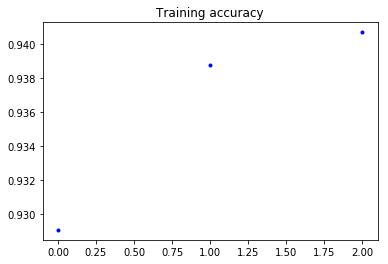

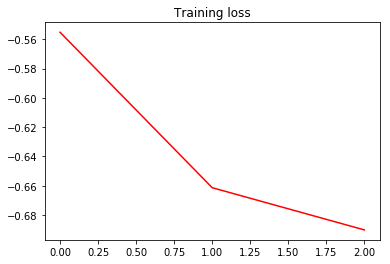

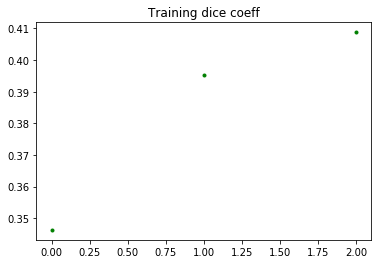

<Figure size 432x288 with 0 Axes>

In [21]:
def plot_training(history):
    acc = history.history['acc']
    print(acc)
    loss = history.history['loss']
    dice_coeff = history.history['dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b.')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'g.')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)